In this document, given an entire 2017-2018 season's worth of player data from the The Süper Lig, Turkish professional soccer league (≈1,700,000 data points), we generate input (aligning player trajectories based in role and then setting new features based on spatiotemporal data) and output data in order to build model for predicting ball location over the pitch.
Due to losses in data, some matches have been extracted, so the total number of matches used is 299.

In [13]:
from __future__ import division

import json
import pickle
import pandas as pd
import numpy as np
import math
from scipy.ndimage.interpolation import shift

from matplotlib import style
import matplotlib.pyplot as plt

style.use('ggplot')

Function for calculating mean of players x,y positions on the pitch

In [7]:
def caluclate_avrg_pos(c_ap_minutes_step, pos_mean, player, pos_count, activity_count):
    avrg_pos_count = 0 
    for c_ap_minutes in range(0,c_ap_minutes_step):
        pos_mean[player][0] += pos_count[player][0][c_ap_minutes]
        pos_mean[player][1] += pos_count[player][1][c_ap_minutes]
        avrg_pos_count += activity_count[player][c_ap_minutes] 
    if avrg_pos_count!=0:
        pos_mean[player][0] /= avrg_pos_count
        pos_mean[player][1] /= avrg_pos_count
    else:
        pos_mean[player][0] = 0 
        pos_mean[player][1] = 0

Function for checking activity over the specific period of time

In [8]:
def caluclate_activity_count(c_ac_minutes_step, player, activity_count):
    
    activity_count_each = 0 
    for c_ac_minutes in range(0, c_ac_minutes_step):
        activity_count_each += activity_count[player][c_ac_minutes] 
    
    if activity_count_each != 0:
        return 1
    else:
        return 0

Function for calculating last number of non-zero activity occurred in last minute

In [9]:
def caluclate_last_nzero_ac_count(player_gorup_len, activity_count):
    
    last_activity_count = 0
    for player_lac_i in range(0, player_gorup_len):
        if activity_count[player_lac_i][1] !=0:
            last_activity_count += 1
            
    return last_activity_count

Function to find the minute that the last non-zero activty occured in

In [10]:
def caluclate_nzero_activity_count(start, end, player, activity_count):
    
    activity_count_each = 0 
    for c_nz_minutes in range(start, end, -1):
        if activity_count[player][c_nz_minutes-1]!=0:
            return c_nz_minutes-1
        
    return -1

Functions for calculating first 15 min of mean of position data of each player. By that way we'll be able to separately calculate each half mean pos data. 

In [11]:
def fist_time_step_mean_data(half, data_persec_t):
    tmp_time_step_t = 0
    
    for t in data_persec_t:

        first_time_step_i = int(t['minute'])*60 + int(t['second'])
        x_pos = t['xpos']
        y_pos = t['ypos']
        team_id_t = int(t['teamId'])
        jersey_number_t = int(t['jerseyNumber'])
        has_ball_teamId_t = int(t['hasballTeamId'])
        math_half = int(t['half'])


        sec = first_time_step_i-(half-1)*45*60
        time_step = math.floor(sec/60)

        if sec==threshold_second:
            break
            
        if tmp_time_step_t == time_step:
            
            tmp_time_step_t += 1
            
            for player_home in range(0, len(home_team_player)):
                home_pos_count_minutes[player_home][0] = (shift(home_pos_count_minutes[player_home][0], -1, cval=0))
                home_pos_count_minutes[player_home][1] = (shift(home_pos_count_minutes[player_home][1], -1, cval=0))
                home_activity_count_minutes[player_home] = (shift(home_activity_count_minutes[player_home], -1, cval=0))
                
            for player_away in range(0, len(away_team_player)):
                away_pos_count_minutes[player_away][0] = (shift(away_pos_count_minutes[player_away][0], -1, cval=0))
                away_pos_count_minutes[player_away][1] = (shift(away_pos_count_minutes[player_away][1], -1, cval=0))
                away_activity_count_minutes[player_away] = (shift(away_activity_count_minutes[player_away], -1, cval=0))

            

        if math_half == half:
            

            if team_id_t == home_team_id:
                
                player_home = home_dict[str(jersey_number_t)]
                if player_positionId['homeTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                    if x_pos!=0 and y_pos !=0:    
                        home_pos_count_minutes[player_home][0][minutes_step-1] += x_pos
                        home_pos_count_minutes[player_home][1][minutes_step-1] += y_pos
                        home_activity_count_minutes[player_home][minutes_step-1] +=1 

                elif has_ball_teamId_t == away_team_id:
                    if x_pos!=0 and y_pos !=0:    
                        home_pos_count_minutes[player_home][0][minutes_step-1] += x_pos
                        home_pos_count_minutes[player_home][1][minutes_step-1] += y_pos
                        home_activity_count_minutes[player_home][minutes_step-1] +=1 

            elif team_id_t == away_team_id:

                player_away = away_dict[str(jersey_number_t)]
                if player_positionId['awayTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                    if x_pos!=0 and y_pos!=0:
                        away_pos_count_minutes[player_away][0][minutes_step-1] += x_pos
                        away_pos_count_minutes[player_away][1][minutes_step-1] += y_pos
                        away_activity_count_minutes[player_away][minutes_step-1] +=1  

                elif has_ball_teamId_t == home_team_id:
                    if x_pos!=0 and y_pos!=0:
                        away_pos_count_minutes[player_away][0][minutes_step-1] += x_pos
                        away_pos_count_minutes[player_away][1][minutes_step-1] += y_pos
                        away_activity_count_minutes[player_away][minutes_step-1] +=1  

                        
    return home_activity_count_minutes, away_activity_count_minutes


Match id:60565
1st half start: 119 sec
half:1	min: 2.0
[[ 17.06875383  35.1341527 ]
 [  0.           0.        ]
 [ 37.88984167  33.09261667]
 [ 41.22228333  20.41690833]
 [ 52.93111667  42.34790833]
 [ 51.021575    11.5996    ]
 [  0.           0.        ]
 [ 53.61726667  29.49373333]
 [  0.           0.        ]
 [ 46.22503333  24.93585   ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.08040833  34.992625  ]
 [  0.           0.        ]
 [ 39.4726      46.29290833]
 [  0.           0.        ]
 [ 39.58865833  14.6606    ]
 [ 65.96771667  21.67235   ]]


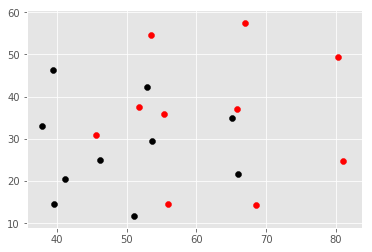



half:1	min: 3.0
[[ 15.1729348   34.15437901]
 [  0.           0.        ]
 [ 33.18242457  33.72828906]
 [ 33.93674068  20.56929236]
 [ 48.88503678  44.58293538]
 [ 46.83275798   9.09683674]
 [  0.           0.        ]
 [ 46.34335112  27.55467365]
 [  0.           0.        ]
 [ 40.62868835  25.36415616]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 61.62244075  27.50717237]
 [  0.           0.        ]
 [ 36.47734563  47.31548906]
 [  0.           0.        ]
 [ 35.8273766   12.55403767]
 [ 57.23520941  21.27977415]]


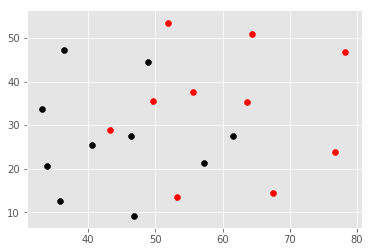



half:1	min: 4.0
[[ 14.03323242  35.17288739]
 [  0.           0.        ]
 [ 34.8794503   34.36018361]
 [ 35.81567763  20.43290419]
 [ 51.19549419  42.2748512 ]
 [ 52.36541788   9.15827536]
 [  0.           0.        ]
 [ 47.82071328  30.08760384]
 [  0.           0.        ]
 [ 42.69744629  28.10709507]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.34933667  29.52853359]
 [  0.           0.        ]
 [ 38.97916362  48.19442122]
 [  0.           0.        ]
 [ 39.96013354  12.04097182]
 [ 58.39688269  26.10381535]]


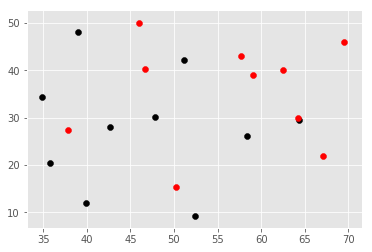



half:1	min: 5.0
[[ 13.78803029  34.65285892]
 [  0.           0.        ]
 [ 34.1663463   34.45095623]
 [ 34.69179822  22.66731384]
 [ 49.15879243  45.6875731 ]
 [ 48.175633    11.00147935]
 [  0.           0.        ]
 [ 47.60753839  26.18095529]
 [  0.           0.        ]
 [ 42.32431574  30.19016834]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 61.33709654  28.0471867 ]
 [  0.           0.        ]
 [ 36.90311707  46.17255628]
 [  0.           0.        ]
 [ 37.30204732  12.50467189]
 [ 54.0370851   28.20945491]]


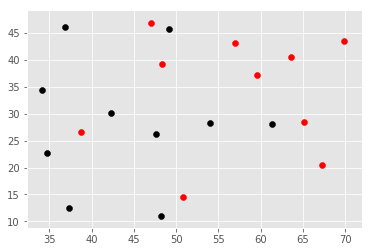



half:1	min: 6.0
[[ 14.90320526  35.13929337]
 [  0.           0.        ]
 [ 34.41533054  34.70936113]
 [ 34.9296095   22.80935652]
 [ 49.72994318  45.95783665]
 [ 48.67289231  11.17990603]
 [  0.           0.        ]
 [ 47.87349243  26.62932124]
 [  0.           0.        ]
 [ 42.65428913  30.43052719]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 61.65924074  28.35101025]
 [  0.           0.        ]
 [ 37.43844023  46.4164772 ]
 [  0.           0.        ]
 [ 37.6685506   12.51496879]
 [ 54.35824676  28.29746199]]


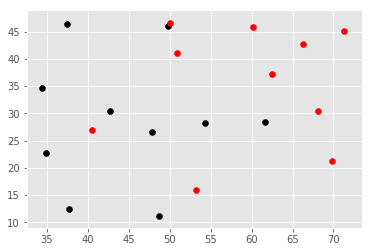



half:1	min: 7.0
[[ 15.24895268  35.19519453]
 [  0.           0.        ]
 [ 34.41533054  34.70936113]
 [ 34.9296095   22.80935652]
 [ 49.72994318  45.95783665]
 [ 48.67289231  11.17990603]
 [  0.           0.        ]
 [ 47.87349243  26.62932124]
 [  0.           0.        ]
 [ 42.65428913  30.43052719]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 61.65924074  28.35101025]
 [  0.           0.        ]
 [ 37.43844023  46.4164772 ]
 [  0.           0.        ]
 [ 37.6685506   12.51496879]
 [ 54.35824676  28.29746199]]


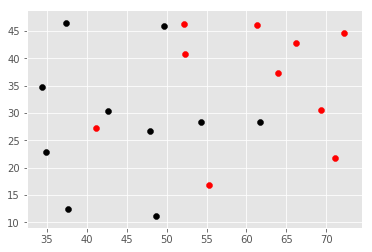



half:1	min: 8.0
[[ 16.06923462  35.37851453]
 [  0.           0.        ]
 [ 35.81774834  34.51910135]
 [ 35.43773584  22.99158378]
 [ 51.04916065  45.75553024]
 [ 50.06839124  12.01919026]
 [  0.           0.        ]
 [ 48.39907912  27.19744475]
 [  0.           0.        ]
 [ 43.98488349  30.79233916]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 61.48136207  28.65765218]
 [  0.           0.        ]
 [ 38.61495398  46.69182798]
 [  0.           0.        ]
 [ 38.69588349  13.01400418]
 [ 55.31022532  28.55974396]]


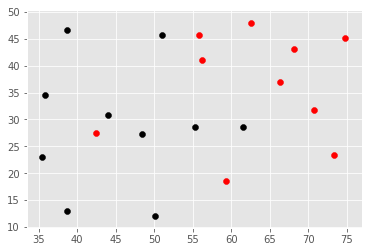



half:1	min: 9.0
[[ 16.91929309  35.18835223]
 [  0.           0.        ]
 [ 38.96791701  35.08257482]
 [ 37.76951649  23.07052219]
 [ 55.91878018  47.67907206]
 [ 53.78034862  12.51049156]
 [  0.           0.        ]
 [ 51.50287039  29.54025827]
 [  0.           0.        ]
 [ 46.8358977   30.8109857 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.63146864  28.46758889]
 [  0.           0.        ]
 [ 40.94932522  48.31781434]
 [  0.           0.        ]
 [ 41.74973071  12.92640644]
 [ 60.45253399  31.57263404]]


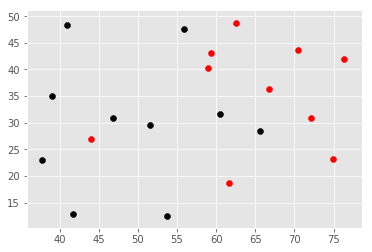



half:1	min: 10.0
[[ 16.86509119  35.1479246 ]
 [  0.           0.        ]
 [ 38.96791701  35.08257482]
 [ 37.76951649  23.07052219]
 [ 55.91878018  47.67907206]
 [ 53.78034862  12.51049156]
 [  0.           0.        ]
 [ 51.50287039  29.54025827]
 [  0.           0.        ]
 [ 46.8358977   30.8109857 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.63146864  28.46758889]
 [  0.           0.        ]
 [ 40.94932522  48.31781434]
 [  0.           0.        ]
 [ 41.74973071  12.92640644]
 [ 60.45253399  31.57263404]]


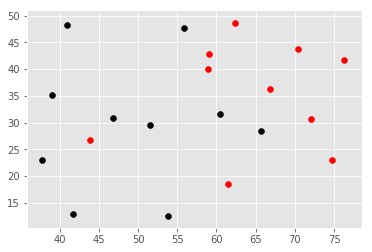



half:1	min: 11.0
[[ 16.86509119  35.1479246 ]
 [  0.           0.        ]
 [ 38.96791701  35.08257482]
 [ 37.76951649  23.07052219]
 [ 55.91878018  47.67907206]
 [ 53.78034862  12.51049156]
 [  0.           0.        ]
 [ 51.50287039  29.54025827]
 [  0.           0.        ]
 [ 46.8358977   30.8109857 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.63146864  28.46758889]
 [  0.           0.        ]
 [ 40.94932522  48.31781434]
 [  0.           0.        ]
 [ 41.74973071  12.92640644]
 [ 60.45253399  31.57263404]]


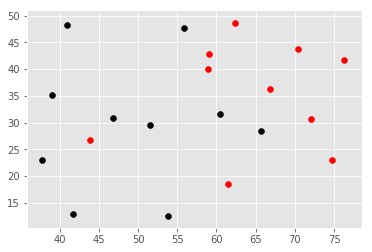



half:1	min: 12.0
[[ 16.77575918  35.23232784]
 [  0.           0.        ]
 [ 38.96791701  35.08257482]
 [ 37.76951649  23.07052219]
 [ 55.91878018  47.67907206]
 [ 53.78034862  12.51049156]
 [  0.           0.        ]
 [ 51.50287039  29.54025827]
 [  0.           0.        ]
 [ 46.8358977   30.8109857 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.63146864  28.46758889]
 [  0.           0.        ]
 [ 40.94932522  48.31781434]
 [  0.           0.        ]
 [ 41.74973071  12.92640644]
 [ 60.45253399  31.57263404]]


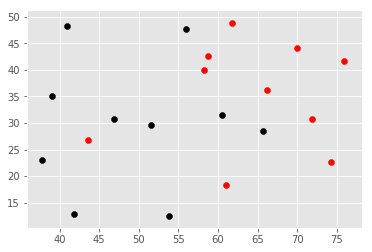



half:1	min: 13.0
[[ 16.29354861  35.847523  ]
 [  0.           0.        ]
 [ 38.94034462  35.23342927]
 [ 37.86463363  23.03862145]
 [ 56.00408405  47.21425101]
 [ 54.1765642   12.67690886]
 [  0.           0.        ]
 [ 51.49249636  29.91018732]
 [  0.           0.        ]
 [ 47.17558536  30.82899804]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.81386416  28.6707745 ]
 [  0.           0.        ]
 [ 41.20023395  48.51217407]
 [  0.           0.        ]
 [ 42.40972949  12.85176505]
 [ 60.59227683  31.93987276]]


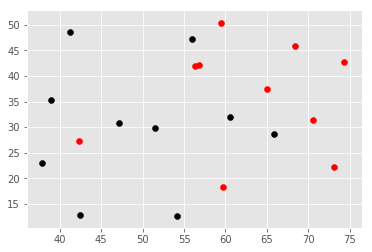



half:1	min: 14.0
[[ 16.73867286  35.75249534]
 [  0.           0.        ]
 [ 39.63365562  35.18662305]
 [ 38.5276201   22.84517573]
 [ 57.0705232   46.21380651]
 [ 55.37502449  12.80204107]
 [  0.           0.        ]
 [ 51.95260044  30.82148048]
 [  0.           0.        ]
 [ 48.13569824  30.20094822]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 66.92523566  29.20164359]
 [  0.           0.        ]
 [ 42.19973188  48.83456446]
 [  0.           0.        ]
 [ 45.07311663  12.72655687]
 [ 61.47680058  31.94280896]]


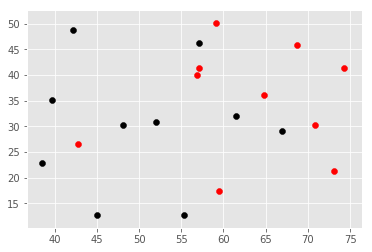



half:1	min: 15.0
[[ 15.42076507  35.35959568]
 [  0.           0.        ]
 [ 35.89831621  34.14431541]
 [ 35.11120755  22.47500793]
 [ 53.03748623  46.52082191]
 [ 50.99976956  12.30336617]
 [  0.           0.        ]
 [ 47.64604008  29.50579623]
 [  0.           0.        ]
 [ 44.05738531  28.2743366 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.54881043  26.45873326]
 [  0.           0.        ]
 [ 38.42521251  46.47052632]
 [  0.           0.        ]
 [ 40.49988319  12.73613804]
 [ 57.62357542  31.09424189]]


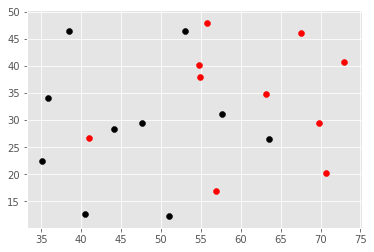



half:1	min: 16.0
[[ 14.54100857  34.76232264]
 [  0.           0.        ]
 [ 35.52710489  33.80930613]
 [ 34.72054323  22.224619  ]
 [ 53.08755495  46.50192718]
 [ 50.58662553  12.27350149]
 [  0.           0.        ]
 [ 47.47525193  29.30048854]
 [  0.           0.        ]
 [ 43.67977071  27.87013764]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 62.90448959  25.85620452]
 [  0.           0.        ]
 [ 38.16039152  46.12172116]
 [  0.           0.        ]
 [ 40.20162219  12.58874118]
 [ 57.24130901  30.549472  ]]


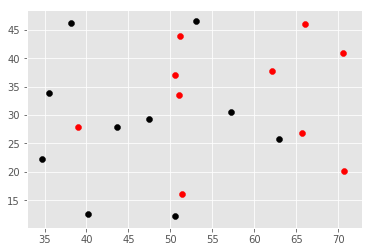



half:1	min: 17.0
[[ 14.28188114  34.77213313]
 [  0.           0.        ]
 [ 35.75142777  33.80542856]
 [ 34.74860447  22.17771377]
 [ 53.47949343  46.10401484]
 [ 51.03483828  12.29491255]
 [  0.           0.        ]
 [ 47.61861406  29.58619886]
 [  0.           0.        ]
 [ 44.00257432  27.62254853]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.4515652   25.3310849 ]
 [  0.           0.        ]
 [ 38.73848336  46.25044109]
 [  0.           0.        ]
 [ 40.91933472  12.28555033]
 [ 57.46555122  31.75984535]]


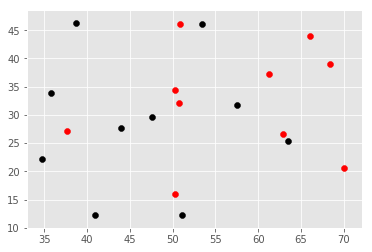



half:1	min: 18.0
[[ 14.25538973  34.81038409]
 [  0.           0.        ]
 [ 35.5737435   33.28999705]
 [ 34.77168282  22.21986594]
 [ 53.68260488  46.57165801]
 [ 49.84319645  12.57589201]
 [  0.           0.        ]
 [ 47.17033542  29.94388918]
 [  0.           0.        ]
 [ 44.21224932  27.08675156]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 62.94570287  23.6686097 ]
 [  0.           0.        ]
 [ 38.20325272  45.74512622]
 [  0.           0.        ]
 [ 40.99808821  12.24520515]
 [ 58.18029026  35.13426023]]


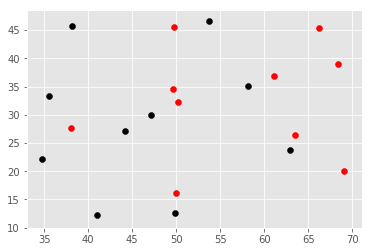



half:1	min: 19.0
[[ 14.51958959  34.61578009]
 [  0.           0.        ]
 [ 36.31866018  33.65584561]
 [ 35.32282297  23.16129018]
 [ 54.40078637  47.81893149]
 [ 50.1723754   13.31124783]
 [  0.           0.        ]
 [ 47.74220326  30.48719165]
 [  0.           0.        ]
 [ 44.93739245  26.9914173 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.3864471   24.98087205]
 [  0.           0.        ]
 [ 38.73310481  46.07562807]
 [  0.           0.        ]
 [ 40.80988411  12.96088694]
 [ 58.54218417  34.38345886]]


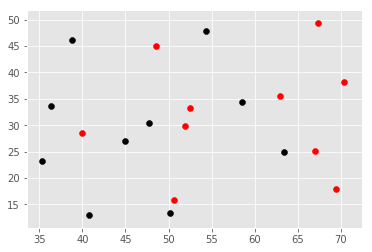



half:1	min: 20.0
[[ 15.32374727  34.91201536]
 [  0.           0.        ]
 [ 38.95041091  34.1716276 ]
 [ 37.84558869  23.13262112]
 [ 58.44177875  48.61852222]
 [ 54.95905181  14.60387263]
 [  0.           0.        ]
 [ 49.41649177  35.14968254]
 [  0.           0.        ]
 [ 50.91443707  27.17378001]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 67.87633245  26.31118015]
 [  0.           0.        ]
 [ 44.6397302   47.07505847]
 [  0.           0.        ]
 [ 44.33933373  13.45657331]
 [ 63.09260398  34.50007213]]


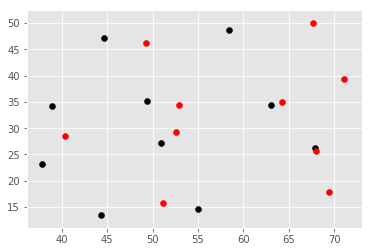



half:1	min: 21.0
[[ 15.06066587  34.84510169]
 [  0.           0.        ]
 [ 39.34034966  34.74501802]
 [ 38.35028273  23.43184584]
 [ 59.03461992  48.45255588]
 [ 54.07579282  14.42002183]
 [  0.           0.        ]
 [ 49.36967144  35.7402992 ]
 [  0.           0.        ]
 [ 51.24572972  27.79981117]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 68.06609232  27.89972372]
 [  0.           0.        ]
 [ 45.41432742  47.42757975]
 [  0.           0.        ]
 [ 44.28886583  13.64642688]
 [ 63.02938536  33.7763776 ]]


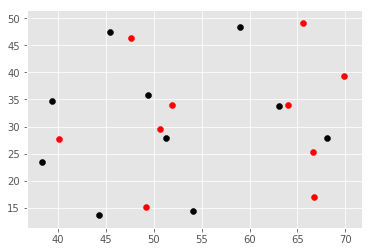



half:1	min: 22.0
[[ 15.2378235   34.83372697]
 [  0.           0.        ]
 [ 39.34034966  34.74501802]
 [ 38.35028273  23.43184584]
 [ 59.03461992  48.45255588]
 [ 54.07579282  14.42002183]
 [  0.           0.        ]
 [ 49.36967144  35.7402992 ]
 [  0.           0.        ]
 [ 51.24572972  27.79981117]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 68.06609232  27.89972372]
 [  0.           0.        ]
 [ 45.41432742  47.42757975]
 [  0.           0.        ]
 [ 44.28886583  13.64642688]
 [ 63.02938536  33.7763776 ]]


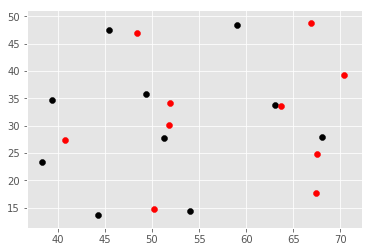



half:1	min: 23.0
[[ 15.12923901  34.73501454]
 [  0.           0.        ]
 [ 39.70840979  34.85362809]
 [ 38.59242136  23.32897155]
 [ 59.05112264  48.59962135]
 [ 53.92609604  14.059838  ]
 [  0.           0.        ]
 [ 49.63711236  35.85084371]
 [  0.           0.        ]
 [ 51.43807865  27.89843084]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 68.82987143  28.23231604]
 [  0.           0.        ]
 [ 45.06583086  47.27978144]
 [  0.           0.        ]
 [ 44.7764481   13.63065166]
 [ 63.30320084  33.38498085]]


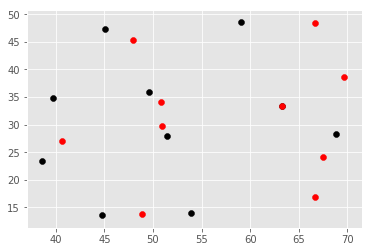



half:1	min: 24.0
[[ 14.03024155  34.9141573 ]
 [  0.           0.        ]
 [ 35.66247742  36.69005867]
 [ 35.52106117  24.87252111]
 [ 52.07046907  50.31701406]
 [ 48.78625878  14.23847052]
 [  0.           0.        ]
 [ 45.86415542  36.82631557]
 [  0.           0.        ]
 [ 48.18595658  28.46592539]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.55539315  30.48659871]
 [  0.           0.        ]
 [ 41.1597924   47.41331371]
 [  0.           0.        ]
 [ 39.9816947   14.85081409]
 [ 58.05650255  34.13563228]]


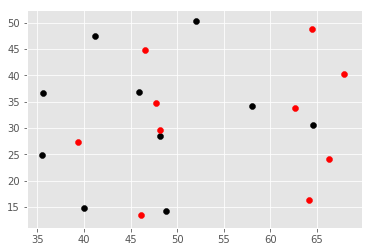



half:1	min: 25.0
[[ 14.02599047  34.93602828]
 [  0.           0.        ]
 [ 35.56972951  36.69204254]
 [ 35.42846549  24.89181226]
 [ 51.95372219  50.30495987]
 [ 48.66255882  14.30051902]
 [  0.           0.        ]
 [ 45.79547544  36.8667183 ]
 [  0.           0.        ]
 [ 48.03117858  28.52541652]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.31809385  30.50642677]
 [  0.           0.        ]
 [ 41.03994326  47.40767816]
 [  0.           0.        ]
 [ 39.86271181  14.90804354]
 [ 57.85693967  34.17637964]]


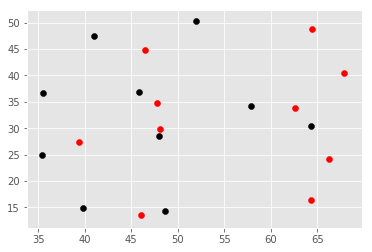



half:1	min: 26.0
[[ 14.02599047  34.93602828]
 [  0.           0.        ]
 [ 35.56972951  36.69204254]
 [ 35.42846549  24.89181226]
 [ 51.95372219  50.30495987]
 [ 48.66255882  14.30051902]
 [  0.           0.        ]
 [ 45.79547544  36.8667183 ]
 [  0.           0.        ]
 [ 48.03117858  28.52541652]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.31809385  30.50642677]
 [  0.           0.        ]
 [ 41.03994326  47.40767816]
 [  0.           0.        ]
 [ 39.86271181  14.90804354]
 [ 57.85693967  34.17637964]]


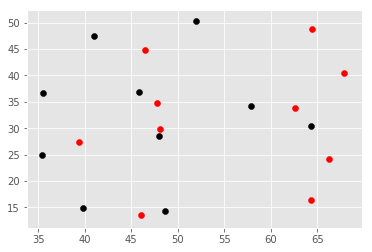



half:1	min: 27.0
[[ 13.87549167  34.88997904]
 [  0.           0.        ]
 [ 35.56972951  36.69204254]
 [ 35.42846549  24.89181226]
 [ 51.95372219  50.30495987]
 [ 48.66255882  14.30051902]
 [  0.           0.        ]
 [ 45.79547544  36.8667183 ]
 [  0.           0.        ]
 [ 48.03117858  28.52541652]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.31809385  30.50642677]
 [  0.           0.        ]
 [ 41.03994326  47.40767816]
 [  0.           0.        ]
 [ 39.86271181  14.90804354]
 [ 57.85693967  34.17637964]]


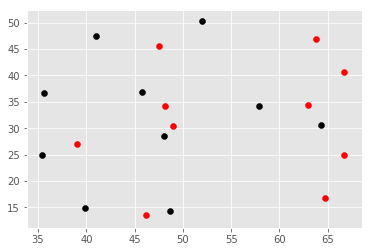



half:1	min: 28.0
[[ 14.72966962  34.71746473]
 [  0.           0.        ]
 [ 36.01908412  36.89137676]
 [ 35.73674361  24.94502195]
 [ 52.27823341  50.41483804]
 [ 48.97284713  14.35888452]
 [  0.           0.        ]
 [ 46.23593091  36.8276691 ]
 [  0.           0.        ]
 [ 47.97829611  28.66660753]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 64.54989521  30.6330216 ]
 [  0.           0.        ]
 [ 41.39462682  47.57047805]
 [  0.           0.        ]
 [ 40.40181021  14.80126249]
 [ 57.97208144  34.17368409]]


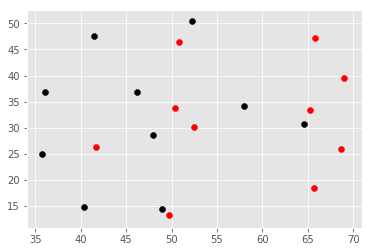



half:1	min: 29.0
[[ 14.90633807  34.80643743]
 [  0.           0.        ]
 [ 36.5362534   36.93747847]
 [ 36.86444749  25.09314834]
 [ 53.5946468   51.56703471]
 [ 50.63796892  14.78654007]
 [  0.           0.        ]
 [ 48.02707838  36.45700699]
 [  0.           0.        ]
 [ 48.28248477  29.34002556]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 66.12319139  30.25655767]
 [  0.           0.        ]
 [ 42.64413554  48.1657339 ]
 [  0.           0.        ]
 [ 40.50229236  14.639504  ]
 [ 58.80582311  34.36802813]]


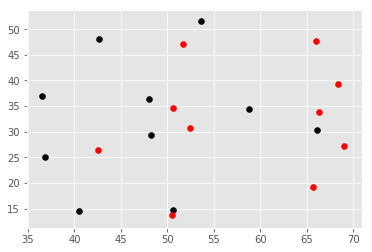



half:1	min: 30.0
[[ 15.8574149   35.3137837 ]
 [  0.           0.        ]
 [ 38.89818587  38.59421963]
 [ 39.44730554  25.84152027]
 [ 56.66933682  52.73334285]
 [ 53.42467072  17.70385573]
 [  0.           0.        ]
 [ 51.4517902   38.62205995]
 [  0.           0.        ]
 [ 51.05430487  31.69627323]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 69.84409611  33.60968693]
 [  0.           0.        ]
 [ 44.87080743  51.00219568]
 [  0.           0.        ]
 [ 43.03303551  15.23098663]
 [ 63.02494279  33.62659411]]


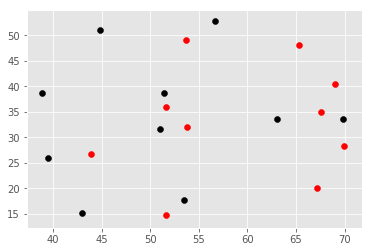



half:1	min: 31.0
[[ 16.3507344   35.9074449 ]
 [  0.           0.        ]
 [ 39.05152674  38.9489374 ]
 [ 39.59915428  26.15702259]
 [ 56.43023293  52.83072849]
 [ 53.67519233  17.70870297]
 [  0.           0.        ]
 [ 51.47745299  38.96830801]
 [  0.           0.        ]
 [ 51.19688556  32.04160707]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 70.26399527  33.97861153]
 [  0.           0.        ]
 [ 44.94865546  51.29820962]
 [  0.           0.        ]
 [ 43.09076382  15.35681502]
 [ 63.3162371   34.09917566]]


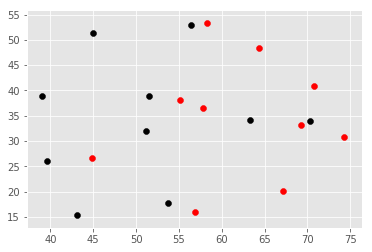



half:1	min: 32.0
[[ 16.50796474  35.93556582]
 [  0.           0.        ]
 [ 38.9055636   39.08982853]
 [ 39.45992273  26.33668887]
 [ 56.26419607  53.36544086]
 [ 53.44751405  17.83877719]
 [  0.           0.        ]
 [ 51.25946825  38.99571891]
 [  0.           0.        ]
 [ 51.07082988  32.3917802 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 70.00719105  34.16401971]
 [  0.           0.        ]
 [ 44.69030572  51.32567532]
 [  0.           0.        ]
 [ 42.73019974  15.53309436]
 [ 63.00223263  33.73306323]]


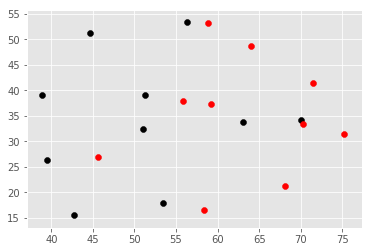



half:1	min: 33.0
[[ 16.90353557  36.16461975]
 [  0.           0.        ]
 [ 40.01137802  40.26759566]
 [ 40.55057289  27.1197508 ]
 [ 57.23535655  54.20436756]
 [ 55.3769216   18.94551754]
 [  0.           0.        ]
 [ 52.59724244  40.47403008]
 [  0.           0.        ]
 [ 52.60979551  33.76958362]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 71.74209392  36.81645858]
 [  0.           0.        ]
 [ 46.38711912  52.31487427]
 [  0.           0.        ]
 [ 43.69403591  16.11215373]
 [ 63.68630494  32.72083462]]


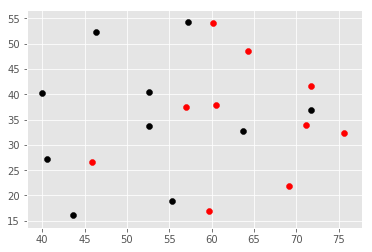



half:1	min: 34.0
[[ 17.18255128  36.27148434]
 [  0.           0.        ]
 [ 39.79294217  40.1949221 ]
 [ 40.44724123  26.75670992]
 [ 56.64067278  54.38241441]
 [ 54.55193309  18.94458425]
 [  0.           0.        ]
 [ 52.57292713  40.92610261]
 [  0.           0.        ]
 [ 52.54464364  34.17001749]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 71.24953917  36.21012385]
 [  0.           0.        ]
 [ 46.19656402  52.44625096]
 [  0.           0.        ]
 [ 43.54139474  15.98312003]
 [ 63.60089457  32.78742657]]


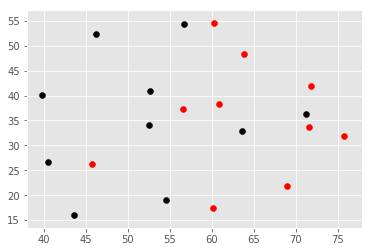



half:1	min: 35.0
[[ 16.94329215  36.48351836]
 [  0.           0.        ]
 [ 38.6433796   40.69381259]
 [ 39.44658654  27.00467248]
 [ 54.90537006  54.49403344]
 [ 52.37114226  18.84672262]
 [  0.           0.        ]
 [ 51.97241729  40.42427332]
 [  0.           0.        ]
 [ 49.05255969  34.05385322]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 69.70166472  36.65856937]
 [  0.           0.        ]
 [ 42.97799212  53.14062173]
 [  0.           0.        ]
 [ 42.23083592  16.06486272]
 [ 62.38471221  33.30403838]]


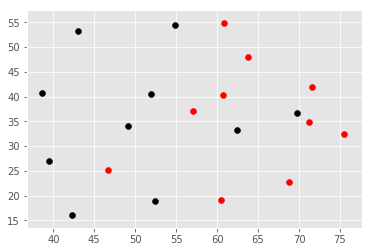



half:1	min: 36.0
[[ 17.23200017  36.47569432]
 [  0.           0.        ]
 [ 40.44973245  40.38077757]
 [ 40.76772464  27.94488557]
 [ 54.3545994   54.07096535]
 [ 53.9924047   19.99070058]
 [  0.           0.        ]
 [ 52.90887905  40.05414908]
 [  0.           0.        ]
 [ 49.3177893   33.62863276]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 70.1214533   35.68666283]
 [  0.           0.        ]
 [ 42.05966625  52.78397079]
 [  0.           0.        ]
 [ 42.45759559  16.57034619]
 [ 63.15736094  34.31113158]]


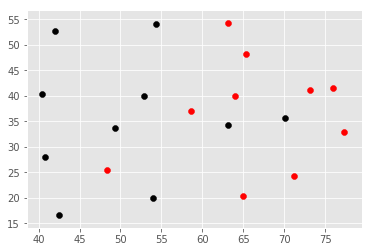



half:1	min: 37.0
[[ 15.79859107  36.26933483]
 [  0.           0.        ]
 [ 36.76114223  39.5360686 ]
 [ 38.86672878  25.43789258]
 [ 50.36921618  54.5526342 ]
 [ 51.29557306  19.50649351]
 [  0.           0.        ]
 [ 48.84965203  40.08658221]
 [  0.           0.        ]
 [ 45.92618417  32.58121175]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 66.11858716  35.26355203]
 [  0.           0.        ]
 [ 38.28352336  51.65439746]
 [  0.           0.        ]
 [ 38.58795526  17.05902168]
 [ 59.61743566  36.39661152]]


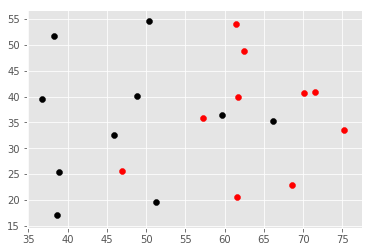



half:1	min: 38.0
[[ 14.34876872  36.1741502 ]
 [  0.           0.        ]
 [ 32.90671091  39.395259  ]
 [ 37.35439617  23.61862478]
 [ 47.02848532  55.26448226]
 [ 44.14832351  19.62358858]
 [  0.           0.        ]
 [ 45.23461416  39.29147611]
 [  0.           0.        ]
 [ 41.48517847  32.14836165]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 62.37982596  35.25399764]
 [  0.           0.        ]
 [ 34.61888673  51.43769735]
 [  0.           0.        ]
 [ 34.33146755  20.21504985]
 [ 54.9111587   37.92747316]]


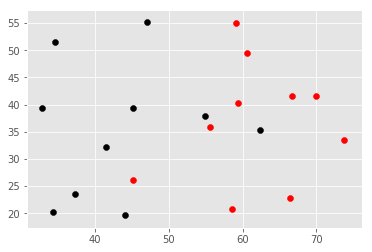



half:1	min: 39.0
[[ 15.04854211  36.46150837]
 [  0.           0.        ]
 [ 34.33431124  38.45441524]
 [ 39.60652305  21.92664495]
 [ 49.96736926  54.4413018 ]
 [ 45.79881132  21.27275963]
 [  0.           0.        ]
 [ 46.66747962  39.02663733]
 [  0.           0.        ]
 [ 41.6628301   32.33390286]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.98739314  34.75823048]
 [  0.           0.        ]
 [ 35.53841752  51.59913829]
 [  0.           0.        ]
 [ 35.8755981   20.89404762]
 [ 56.57520267  37.301416  ]]


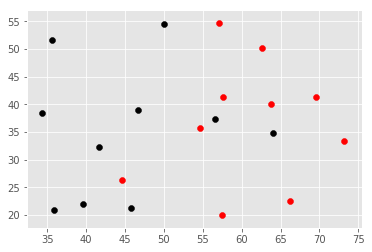



half:1	min: 40.0
[[ 15.35484141  36.18216933]
 [  0.           0.        ]
 [ 34.84042509  37.96760309]
 [ 40.44059371  23.26162626]
 [ 51.01118459  52.18465269]
 [ 47.16769428  25.17591297]
 [  0.           0.        ]
 [ 47.50769588  38.41933677]
 [  0.           0.        ]
 [ 42.40701168  32.47710137]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 65.12740722  34.29409897]
 [  0.           0.        ]
 [ 36.81752852  51.39122062]
 [  0.           0.        ]
 [ 37.30802131  20.24324364]
 [ 57.90404536  37.47054845]]


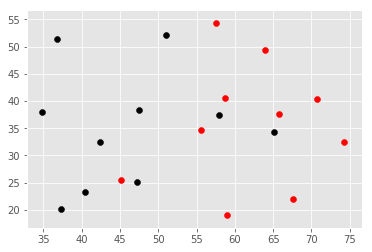



half:1	min: 41.0
[[ 14.8503033   35.97082129]
 [  0.           0.        ]
 [ 33.7781399   37.62693563]
 [ 39.15342733  23.60170463]
 [ 49.90295795  50.76499726]
 [ 45.92650996  25.92180454]
 [  0.           0.        ]
 [ 45.81394384  38.34664729]
 [  0.           0.        ]
 [ 40.85830608  32.43016519]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.13070049  34.41504598]
 [  0.           0.        ]
 [ 35.51528243  51.02581412]
 [  0.           0.        ]
 [ 36.42642167  20.52983777]
 [ 56.17788112  37.01860952]]


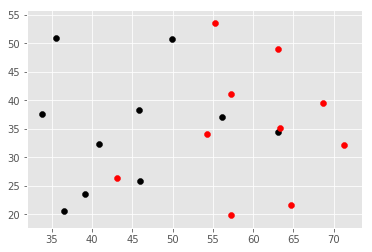



half:1	min: 42.0
[[ 15.28003288  36.09774418]
 [  0.           0.        ]
 [ 34.06990894  37.72413789]
 [ 39.30734471  23.61668726]
 [ 50.31860981  50.47075871]
 [ 46.37756183  26.0353726 ]
 [  0.           0.        ]
 [ 46.15644423  38.54224553]
 [  0.           0.        ]
 [ 41.12825171  32.5018748 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 63.43093073  34.43465756]
 [  0.           0.        ]
 [ 36.07986407  51.11224195]
 [  0.           0.        ]
 [ 36.80082992  20.4906878 ]
 [ 56.41151252  36.99100455]]


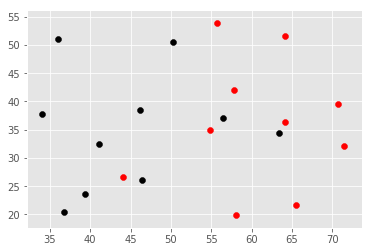



half:1	min: 43.0
[[ 14.25143837  35.98283011]
 [  0.           0.        ]
 [ 33.51882724  37.40312115]
 [ 38.72356998  23.62544478]
 [ 49.618896    49.38734333]
 [ 45.60069541  27.17334799]
 [  0.           0.        ]
 [ 45.53008686  38.52812244]
 [  0.           0.        ]
 [ 40.86959712  32.22395513]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 62.92514327  34.02843237]
 [  0.           0.        ]
 [ 35.3026266   50.80539519]
 [  0.           0.        ]
 [ 35.70900641  20.56694423]
 [ 56.20664679  37.03800673]]


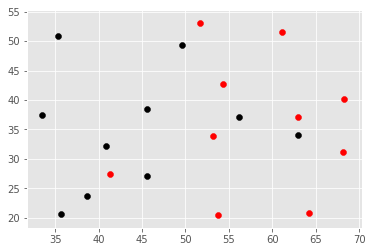



half:1	min: 44.0
[[ 13.4336462   35.99297946]
 [  0.           0.        ]
 [ 31.85741905  37.44708042]
 [ 36.96981979  23.57965391]
 [ 46.46190497  48.5590302 ]
 [ 41.57296647  28.28507159]
 [  0.           0.        ]
 [ 42.51552487  38.83062928]
 [  0.           0.        ]
 [ 38.90774321  32.1679418 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 59.75869665  34.64428571]
 [  0.           0.        ]
 [ 32.38789982  50.14296155]
 [  0.           0.        ]
 [ 33.29728663  21.59102175]
 [ 53.92990476  37.20857178]]


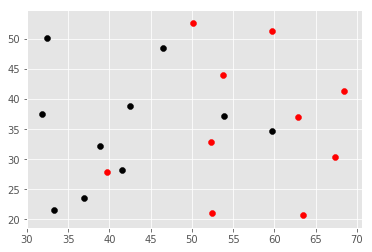



half:1	min: 45.0
[[ 12.74841288  35.67134293]
 [  0.           0.        ]
 [ 29.31585079  36.21765986]
 [ 35.85435002  22.63676365]
 [ 41.96359185  45.83464556]
 [ 36.42582109  28.83717945]
 [  0.           0.        ]
 [ 38.12775329  38.24557007]
 [  0.           0.        ]
 [ 34.78678141  30.9760712 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 53.98779728  33.41422721]
 [  0.           0.        ]
 [ 28.83923492  47.98097188]
 [  0.           0.        ]
 [ 30.36669563  23.43454023]
 [ 48.85934907  40.55300556]]


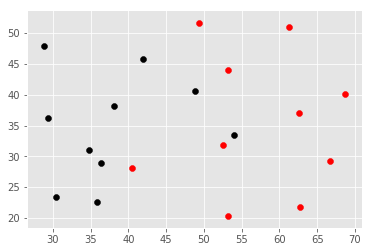



half:1	min: 46.0
[[ 12.87848234  35.57465158]
 [  0.           0.        ]
 [ 29.73129464  36.58447395]
 [ 35.2098211   23.13771805]
 [ 43.14079719  47.17731847]
 [ 38.61237828  29.93380712]
 [  0.           0.        ]
 [ 39.41725364  39.30146628]
 [  0.           0.        ]
 [ 36.07122912  30.47670192]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 53.53286858  31.23126322]
 [  0.           0.        ]
 [ 30.00597433  48.71837663]
 [  0.           0.        ]
 [ 31.05838411  21.68068915]
 [ 49.73136686  40.71886511]]


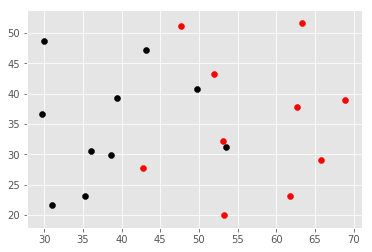



half:1	min: 47.0
[[ 13.32335259  35.30244483]
 [  0.           0.        ]
 [ 31.61778785  36.30662674]
 [ 36.5675088   22.90150107]
 [ 46.11008696  47.56027029]
 [ 42.01920019  29.34067458]
 [  0.           0.        ]
 [ 42.69481215  37.73805382]
 [  0.           0.        ]
 [ 38.58141528  29.81125799]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 57.18279965  30.57929757]
 [  0.           0.        ]
 [ 32.48523681  48.77901979]
 [  0.           0.        ]
 [ 33.96482912  20.69605789]
 [ 52.97642046  40.61622399]]


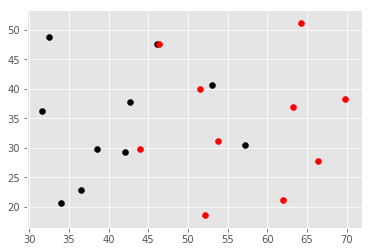



half:1	min: 48.0
[[ 13.46003047  35.2583411 ]
 [  0.           0.        ]
 [ 31.98705488  36.25016599]
 [ 36.73939409  22.85705568]
 [ 46.43876491  47.52431825]
 [ 42.67410596  28.78110188]
 [  0.           0.        ]
 [ 43.13241515  37.47714983]
 [  0.           0.        ]
 [ 39.0593569   29.61470404]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 57.94946566  30.06166431]
 [  0.           0.        ]
 [ 32.83050606  48.74089663]
 [  0.           0.        ]
 [ 34.27492415  20.3782102 ]
 [ 53.52963077  40.56182017]]


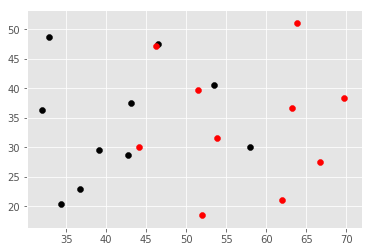



half:1	min: 49.0
[[ 13.52273174  35.08729622]
 [  0.           0.        ]
 [ 31.37698421  36.29042386]
 [ 36.35431068  22.7690527 ]
 [ 46.43876491  47.52431825]
 [ 42.08620292  29.31186532]
 [  0.           0.        ]
 [ 42.47411509  36.91976281]
 [  0.           0.        ]
 [ 38.38783263  29.19248246]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 57.73122561  29.82670491]
 [  0.           0.        ]
 [ 32.25973474  48.49333825]
 [  0.           0.        ]
 [ 33.77587872  20.51799504]
 [ 53.14686845  40.84043672]]


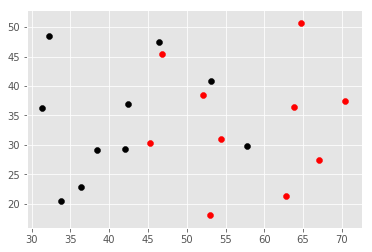



2nd half start: 359 sec
half:2	min: 51.0
[[  8.0518453   33.8388115 ]
 [  0.           0.        ]
 [ 28.4675578   42.42299366]
 [ 25.26393478  24.15670355]
 [ 33.76057257  48.45467926]
 [ 33.83863119  13.91297605]
 [  0.           0.        ]
 [ 44.7151618   36.22834387]
 [  0.           0.        ]
 [ 35.41857308  34.03776242]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 49.28587123  32.28653234]
 [  0.           0.        ]
 [ 26.02287062  47.81759053]
 [  0.           0.        ]
 [ 25.77427229  21.2951223 ]
 [ 37.71675027  33.82988956]]


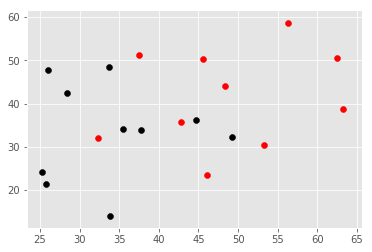



half:2	min: 52.0
[[  7.70354766  34.04723527]
 [  0.           0.        ]
 [ 27.78153295  40.68452445]
 [ 28.18913391  23.67934583]
 [ 36.47240218  49.13557392]
 [ 35.68332106  12.5879642 ]
 [  0.           0.        ]
 [ 42.04226913  32.87704382]
 [  0.           0.        ]
 [ 35.61494683  34.47724162]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 50.02472818  32.12864183]
 [  0.           0.        ]
 [ 27.05991226  47.43012578]
 [  0.           0.        ]
 [ 26.67660461  20.2693311 ]
 [ 37.40220309  30.93388629]]


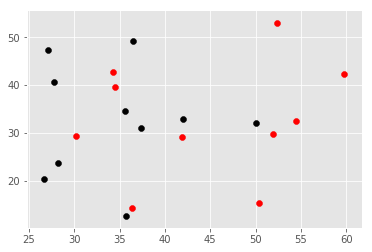



half:2	min: 53.0
[[  9.29253705  33.53412448]
 [  0.           0.        ]
 [ 29.14766531  39.77337401]
 [ 30.12700095  23.43112692]
 [ 39.5236325   49.271143  ]
 [ 38.09540593  12.00448453]
 [  0.           0.        ]
 [ 42.70921654  32.11535374]
 [  0.           0.        ]
 [ 37.56166571  35.15468898]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.68665666  31.92312548]
 [  0.           0.        ]
 [ 29.23232236  47.33336025]
 [  0.           0.        ]
 [ 28.59075629  19.13630783]
 [ 40.21425752  29.53341027]]


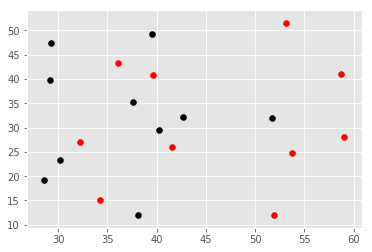



half:2	min: 54.0
[[  9.52300836  33.50345085]
 [  0.           0.        ]
 [ 29.36043872  39.52584456]
 [ 30.32008442  23.54441867]
 [ 39.88687726  49.39113145]
 [ 38.6137543   12.30768861]
 [  0.           0.        ]
 [ 42.99023478  32.44617215]
 [  0.           0.        ]
 [ 37.89802027  34.81068963]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.34049773  32.54079023]
 [  0.           0.        ]
 [ 29.53104026  47.64450926]
 [  0.           0.        ]
 [ 29.29029485  19.08814068]
 [ 41.18448566  29.3848191 ]]


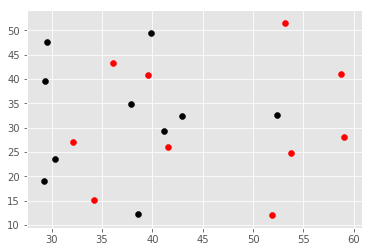



half:2	min: 55.0
[[  9.25537556  33.18118834]
 [  0.           0.        ]
 [ 29.31157149  38.81216781]
 [ 30.14686135  23.17399143]
 [ 40.34584627  49.47607439]
 [ 38.88714474  11.95520792]
 [  0.           0.        ]
 [ 42.63454342  31.67531292]
 [  0.           0.        ]
 [ 37.80093104  33.15039547]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.16728224  31.22098541]
 [  0.           0.        ]
 [ 29.56168367  47.28386033]
 [  0.           0.        ]
 [ 29.72254553  18.27660217]
 [ 41.8441132   29.30595635]]


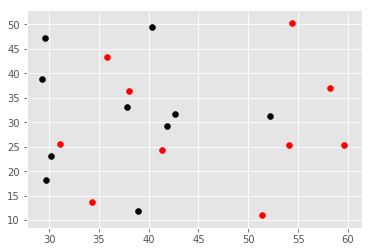



half:2	min: 56.0
[[  9.50685932  33.02939629]
 [  0.           0.        ]
 [ 29.48300427  38.64185316]
 [ 30.30919997  23.15688708]
 [ 40.80315436  49.59236525]
 [ 39.22490093  12.05066472]
 [  0.           0.        ]
 [ 42.84162816  31.58615622]
 [  0.           0.        ]
 [ 38.22068388  33.22791757]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.47389699  31.4064398 ]
 [  0.           0.        ]
 [ 29.80725207  47.28542158]
 [  0.           0.        ]
 [ 29.94229553  18.07366244]
 [ 42.53188818  29.22692796]]


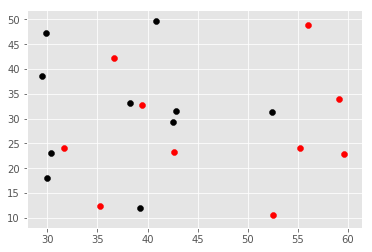



half:2	min: 57.0
[[  9.41908866  32.83569741]
 [  0.           0.        ]
 [ 29.21115768  38.23167831]
 [ 29.8902033   23.15616586]
 [ 40.4710671   49.74059934]
 [ 38.93415012  11.93821927]
 [  0.           0.        ]
 [ 42.44850813  31.14315452]
 [  0.           0.        ]
 [ 38.15904452  33.46749452]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.56470593  32.49386634]
 [  0.           0.        ]
 [ 29.62836395  47.08772495]
 [  0.           0.        ]
 [ 29.59307862  17.91349042]
 [ 42.54354517  28.6747592 ]]


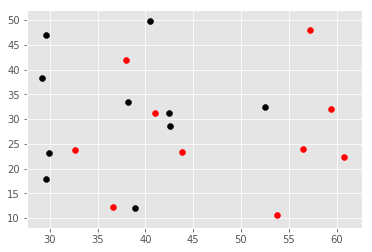



half:2	min: 58.0
[[  9.33740598  32.83431775]
 [  0.           0.        ]
 [ 28.82310773  38.35162198]
 [ 29.40773204  23.41054064]
 [ 40.3045201   49.54935191]
 [ 38.26347959  12.22849328]
 [  0.           0.        ]
 [ 42.04235746  31.10387917]
 [  0.           0.        ]
 [ 37.51216264  33.4213058 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.58424176  32.36086825]
 [  0.           0.        ]
 [ 29.19775009  47.06856031]
 [  0.           0.        ]
 [ 29.31533833  18.11343306]
 [ 41.77117777  28.8786824 ]]


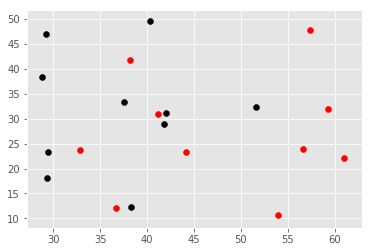



half:2	min: 59.0
[[  9.10275516  32.88529908]
 [  0.           0.        ]
 [ 28.82310773  38.35162198]
 [ 28.43285554  24.43907351]
 [ 39.4104529   49.63366648]
 [ 36.74441303  13.46063696]
 [  0.           0.        ]
 [ 40.21598224  32.08369084]
 [  0.           0.        ]
 [ 36.25937345  33.33486828]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 49.22995361  33.09136846]
 [  0.           0.        ]
 [ 28.11434466  47.00878429]
 [  0.           0.        ]
 [ 28.77571758  18.98488699]
 [ 39.86610156  29.41700346]]


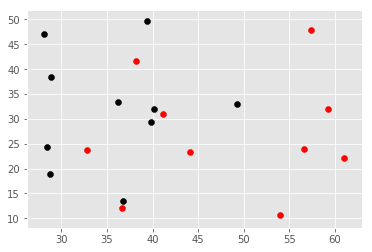



half:2	min: 60.0
[[ 10.70315082  32.89500029]
 [  0.           0.        ]
 [ 30.29907816  37.43998906]
 [ 30.23800301  23.6647411 ]
 [ 41.86488028  49.31502281]
 [ 39.24868645  13.01242943]
 [  0.           0.        ]
 [ 42.34240282  30.41572711]
 [  0.           0.        ]
 [ 38.25330899  32.28819497]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.2040042   31.55720595]
 [  0.           0.        ]
 [ 29.91917987  46.70467592]
 [  0.           0.        ]
 [ 31.58220783  17.79033547]
 [ 42.63117883  29.53085871]]


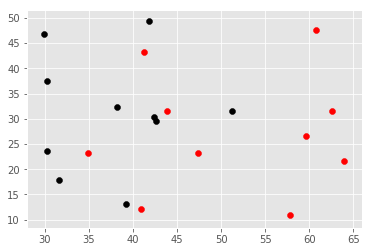



half:2	min: 61.0
[[ 11.1720815   32.87120184]
 [  0.           0.        ]
 [ 30.8209355   37.36615255]
 [ 30.41941312  23.69645524]
 [ 42.13371983  48.97315257]
 [ 39.72609391  13.15323455]
 [  0.           0.        ]
 [ 42.47983148  30.43339326]
 [  0.           0.        ]
 [ 38.65914942  32.27844114]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.51880105  31.56907768]
 [  0.           0.        ]
 [ 30.12954741  46.68421762]
 [  0.           0.        ]
 [ 31.98201686  17.86909874]
 [ 43.0381138   29.64050856]]


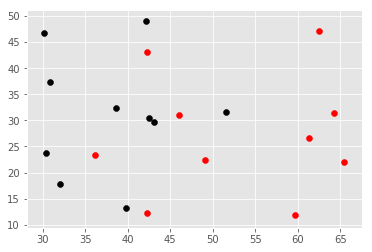



half:2	min: 62.0
[[ 11.49951261  32.6198183 ]
 [  0.           0.        ]
 [ 32.8700379   36.65520439]
 [ 31.12512972  23.21091255]
 [ 43.20172805  44.5743513 ]
 [ 39.99875011  14.76357583]
 [  0.           0.        ]
 [ 43.18049429  29.25385092]
 [  0.           0.        ]
 [ 40.30620432  32.1806529 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.08325391  31.25141364]
 [  0.           0.        ]
 [ 31.04873611  46.64304267]
 [  0.           0.        ]
 [ 34.69090547  17.39905914]
 [ 44.59918545  29.40843577]]


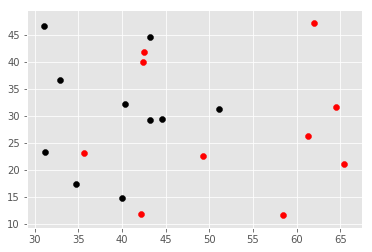



half:2	min: 63.0
[[ 11.98727207  33.05143383]
 [  0.           0.        ]
 [ 33.24765448  36.7408262 ]
 [ 31.5219038   23.26047528]
 [ 44.15841289  43.46486871]
 [ 41.18964992  15.24723451]
 [  0.           0.        ]
 [ 44.09737026  28.75350618]
 [  0.           0.        ]
 [ 40.92429299  32.21085943]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.93291806  31.36457691]
 [  0.           0.        ]
 [ 31.9155039   46.82386366]
 [  0.           0.        ]
 [ 35.15618344  17.17133894]
 [ 45.41952103  29.76776163]]


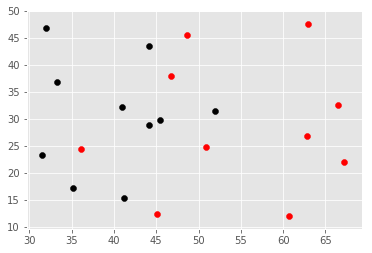



half:2	min: 64.0
[[ 12.13677656  33.07149127]
 [  0.           0.        ]
 [ 33.24765448  36.7408262 ]
 [ 31.5219038   23.26047528]
 [ 44.15841289  43.46486871]
 [ 41.18964992  15.24723451]
 [  0.           0.        ]
 [ 44.09737026  28.75350618]
 [  0.           0.        ]
 [ 40.92429299  32.21085943]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.93291806  31.36457691]
 [  0.           0.        ]
 [ 31.9155039   46.82386366]
 [  0.           0.        ]
 [ 35.15618344  17.17133894]
 [ 45.41952103  29.76776163]]


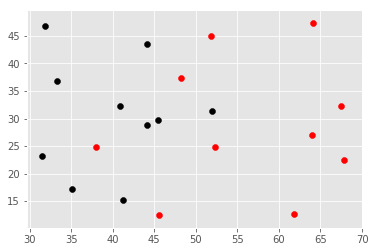



half:2	min: 65.0
[[ 11.94717719  33.06258809]
 [  0.           0.        ]
 [ 33.53415736  36.66730079]
 [ 31.78952576  23.3089088 ]
 [ 44.81252283  43.80033193]
 [ 41.82328916  15.1693843 ]
 [  0.           0.        ]
 [ 44.3851625   28.61694301]
 [  0.           0.        ]
 [ 41.37999931  32.28968685]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.3865677   31.02279326]
 [  0.           0.        ]
 [ 32.31562323  46.92942791]
 [  0.           0.        ]
 [ 35.43660495  16.91210863]
 [ 46.22358484  29.7568814 ]]


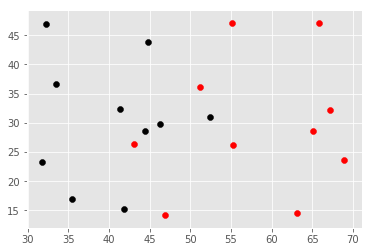



half:2	min: 66.0
[[ 12.3754329   32.74208743]
 [  0.           0.        ]
 [ 34.1709132   32.88661068]
 [ 33.29968057  22.57193598]
 [ 48.29274209  41.85258195]
 [ 43.28624475  14.68432223]
 [  0.           0.        ]
 [ 42.24648457  23.69331767]
 [  0.           0.        ]
 [ 42.16713856  30.67037164]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.44630237  27.652314  ]
 [  0.           0.        ]
 [ 33.63971187  46.02928025]
 [  0.           0.        ]
 [ 37.72854918  14.39500539]
 [ 49.41259279  26.62740659]]


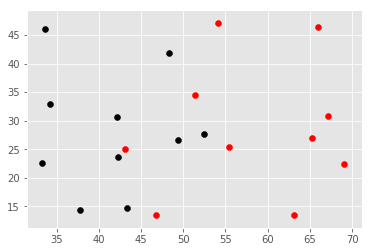



half:2	min: 67.0
[[ 13.32798446  32.41733206]
 [  0.           0.        ]
 [ 35.89603018  32.29005133]
 [ 32.69129826  22.61863417]
 [ 49.09076828  40.0816298 ]
 [ 43.75505092  15.80093592]
 [  0.           0.        ]
 [ 43.7396929   23.7501764 ]
 [  0.           0.        ]
 [ 43.32035674  29.69922389]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 52.48347331  26.92655763]
 [  0.           0.        ]
 [ 34.34095288  45.97065067]
 [  0.           0.        ]
 [ 38.75584431  14.14607784]
 [ 51.92398377  27.42902953]]


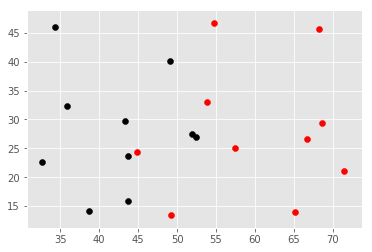



half:2	min: 68.0
[[ 13.91749586  32.76797991]
 [  0.           0.        ]
 [ 39.32660166  31.82160901]
 [ 33.25099234  22.6247506 ]
 [ 50.99734927  35.27353708]
 [ 45.75545987  17.591874  ]
 [  0.           0.        ]
 [ 45.55539456  23.79075864]
 [  0.           0.        ]
 [ 46.43338108  28.37070964]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 53.77948079  27.93290705]
 [  0.           0.        ]
 [ 35.12440861  45.21138017]
 [  0.           0.        ]
 [ 41.07648012  13.8410419 ]
 [ 51.6942232   27.36409221]]


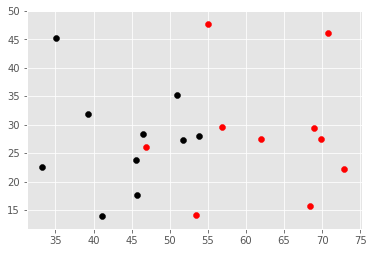



half:2	min: 69.0
[[ 13.49289156  32.95732672]
 [  0.           0.        ]
 [ 38.06789349  31.56692885]
 [ 32.00499602  22.62885963]
 [ 49.55944225  31.03247463]
 [ 43.66111772  18.08114983]
 [  0.           0.        ]
 [ 43.83683768  23.37542918]
 [  0.           0.        ]
 [ 45.83979257  26.82868653]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.1647083   28.17510761]
 [  0.           0.        ]
 [ 34.12334994  43.77004232]
 [  0.           0.        ]
 [ 40.30667332  13.37609022]
 [ 49.1901833   26.99714913]]


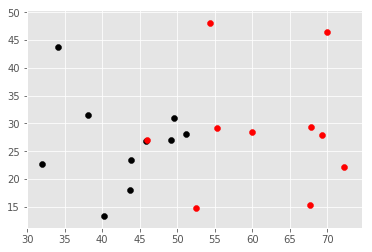



half:2	min: 70.0
[[ 13.15589094  33.06769385]
 [  0.           0.        ]
 [ 34.29824731  32.42825793]
 [ 29.32514003  24.59557016]
 [ 44.13377599  26.11557244]
 [ 38.87436093  21.10198962]
 [  0.           0.        ]
 [ 39.5635353   23.89471781]
 [  0.           0.        ]
 [ 41.18114136  27.99721075]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 45.84304611  29.108815  ]
 [  0.           0.        ]
 [ 30.77004634  41.71913921]
 [  0.           0.        ]
 [ 36.28187238  15.00407765]
 [ 43.50091568  27.9250458 ]]


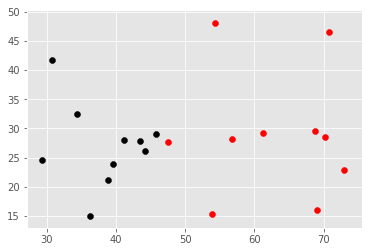



half:2	min: 71.0
[[ 13.1237978   33.22192781]
 [  0.           0.        ]
 [ 34.30002357  32.4456198 ]
 [ 29.23751343  24.67460096]
 [ 43.9997371   25.36569827]
 [ 38.7291668   21.33724153]
 [  0.           0.        ]
 [ 39.38090856  23.72702112]
 [  0.           0.        ]
 [ 40.96328375  27.85643109]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 45.50486576  28.84997624]
 [  0.           0.        ]
 [ 30.76075719  41.55963616]
 [  0.           0.        ]
 [ 36.25747196  15.11872638]
 [ 42.87986469  27.96440364]]


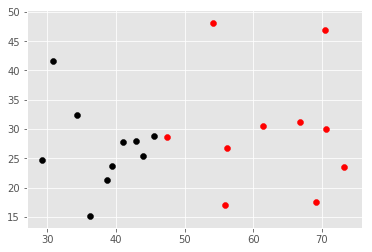



half:2	min: 72.0
[[ 13.44294662  33.3891505 ]
 [  0.           0.        ]
 [ 34.96378256  33.63939744]
 [ 30.64937204  25.60480629]
 [ 47.62477358  28.8639076 ]
 [ 39.19282998  20.74194771]
 [  0.           0.        ]
 [ 40.60359196  25.20029377]
 [  0.           0.        ]
 [ 42.35782383  29.61648186]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 49.22402546  27.55397843]
 [  0.           0.        ]
 [ 32.22331044  43.45111851]
 [  0.           0.        ]
 [ 38.76168435  15.61635978]
 [ 45.8656349   29.32877601]]


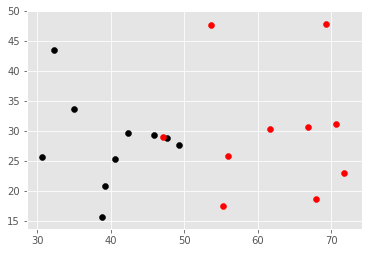



half:2	min: 73.0
[[ 13.67650583  33.15107644]
 [  0.           0.        ]
 [ 35.57735128  33.34873242]
 [ 31.24649514  25.34782516]
 [ 48.19565626  28.71317478]
 [ 40.19209751  20.65212115]
 [  0.           0.        ]
 [ 41.26465546  24.88353253]
 [  0.           0.        ]
 [ 43.22660874  29.44595537]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 50.22002178  27.46139932]
 [  0.           0.        ]
 [ 32.86163672  43.36633346]
 [  0.           0.        ]
 [ 39.32769522  15.30126231]
 [ 46.84229513  29.13743206]]


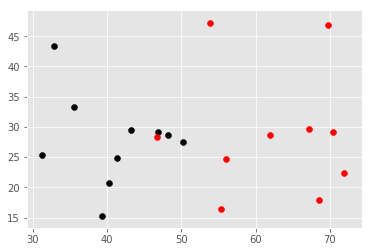



half:2	min: 74.0
[[ 14.03768403  33.1061556 ]
 [  0.           0.        ]
 [ 35.64295072  33.27039568]
 [ 32.467348    24.31619178]
 [ 49.68901631  27.58563395]
 [ 42.27644946  20.10913464]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 44.9464905   29.25498585]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 58.28298333  13.8663125 ]
 [  0.           0.        ]
 [ 52.5665139   26.22277063]
 [  0.           0.        ]
 [ 34.30057067  43.13354104]
 [  0.           0.        ]
 [ 40.51774832  14.16799456]
 [ 49.40429045  28.46377206]]


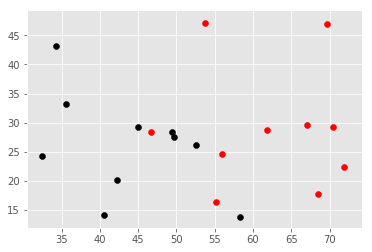



half:2	min: 75.0
[[ 13.89233604  33.43761783]
 [  0.           0.        ]
 [ 35.00578823  34.1786511 ]
 [ 31.2261184   25.2909176 ]
 [ 48.2818089   26.85871382]
 [ 40.63180252  21.23704982]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 43.80600103  30.60549797]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 58.44528033  21.52788646]
 [  0.           0.        ]
 [ 51.5172672   27.880756  ]
 [  0.           0.        ]
 [ 33.43829849  43.51378723]
 [  0.           0.        ]
 [ 38.64559179  15.21447221]
 [ 47.95963684  28.06028291]]


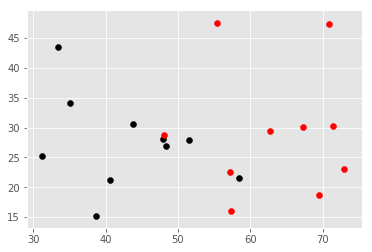



half:2	min: 76.0
[[ 13.27648069  33.24385058]
 [  0.           0.        ]
 [ 33.83307554  33.86538754]
 [ 30.58469734  24.74818768]
 [ 48.14418076  28.13364791]
 [ 40.28184427  19.82214024]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.62073846  29.97859246]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 53.21879022  19.81060014]
 [  0.           0.        ]
 [ 51.5493493   26.80664932]
 [  0.           0.        ]
 [ 33.02236543  43.36976034]
 [  0.           0.        ]
 [ 37.66437029  14.51807265]
 [ 47.71921644  26.72875094]]


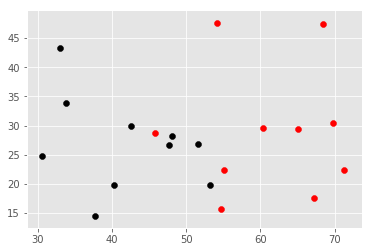



half:2	min: 77.0
[[ 13.07256742  33.35978149]
 [  0.           0.        ]
 [ 31.58626536  34.57166329]
 [ 29.8581839   25.80030716]
 [ 48.10933841  32.66681643]
 [ 41.55800675  17.91095851]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 40.96667948  29.87047812]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 51.22115737  22.76828098]
 [  0.           0.        ]
 [ 53.57881384  26.05545758]
 [  0.           0.        ]
 [ 32.48653205  43.59446411]
 [  0.           0.        ]
 [ 35.15370877  14.64059819]
 [ 47.69760806  27.54830911]]


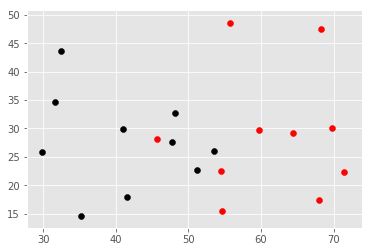



half:2	min: 78.0
[[ 12.63547712  32.90920454]
 [  0.           0.        ]
 [ 31.44304896  34.23483606]
 [ 31.5115863   26.4726149 ]
 [ 46.7946953   36.42018347]
 [ 40.34731447  16.16590078]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 38.95361328  28.47858587]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 50.20531737  22.14200548]
 [  0.           0.        ]
 [ 53.63460153  24.46556502]
 [  0.           0.        ]
 [ 31.80165928  43.59550509]
 [  0.           0.        ]
 [ 34.47465513  14.43727198]
 [ 48.49920985  29.19031491]]


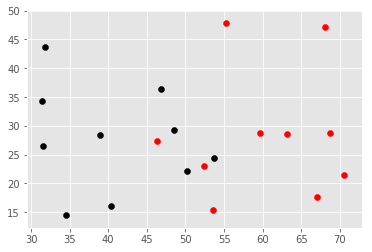



half:2	min: 79.0
[[ 12.52001977  32.88025148]
 [  0.           0.        ]
 [ 31.54783952  34.07811876]
 [ 32.13788924  26.61663806]
 [ 46.81730269  37.02276936]
 [ 40.5974197   15.93080895]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 38.73839671  28.23575332]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 50.10014942  22.13490301]
 [  0.           0.        ]
 [ 54.03688915  24.3265533 ]
 [  0.           0.        ]
 [ 32.22465372  43.42156486]
 [  0.           0.        ]
 [ 34.49798583  14.37348601]
 [ 48.83079764  29.49242699]]


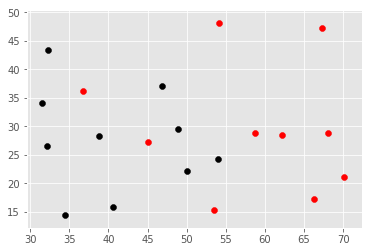



half:2	min: 80.0
[[ 12.56137448  32.98583066]
 [  0.           0.        ]
 [ 32.96874333  34.72331168]
 [ 32.43457027  26.93097168]
 [ 47.27307645  33.38472691]
 [ 41.81102697  19.59404503]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 40.51045916  30.7909361 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 48.72341653  26.53740431]
 [  0.           0.        ]
 [ 52.50380606  25.66510069]
 [  0.           0.        ]
 [ 33.4976991   44.41759849]
 [  0.           0.        ]
 [ 34.09595296  14.61496325]
 [ 47.45467295  32.74198184]]


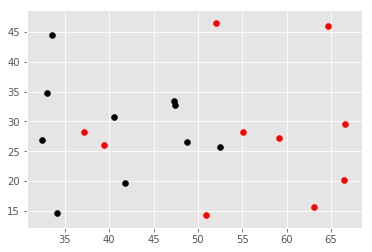



half:2	min: 81.0
[[ 12.76614142  33.15525796]
 [  0.           0.        ]
 [ 33.94778877  35.14480157]
 [ 33.39358115  27.1283024 ]
 [ 49.24885399  32.58506908]
 [ 43.96131072  20.94816644]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.93865605  31.53261631]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 47.84558785  26.70678092]
 [  0.           0.        ]
 [ 52.68255357  26.99874897]
 [  0.           0.        ]
 [ 34.67819214  44.46874265]
 [  0.           0.        ]
 [ 35.70246525  14.67521073]
 [ 48.1453      33.11574049]]


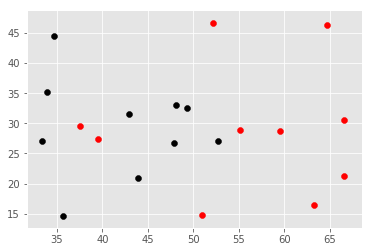



half:2	min: 82.0
[[ 12.51377465  33.23522347]
 [  0.           0.        ]
 [ 33.78306349  35.05939797]
 [ 33.24283672  27.05419176]
 [ 49.1118704   32.80542499]
 [ 43.82133827  20.91799751]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 43.11229495  31.4554509 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 47.4492277   26.76035486]
 [  0.           0.        ]
 [ 52.28945273  26.92815631]
 [  0.           0.        ]
 [ 34.52836752  44.33537438]
 [  0.           0.        ]
 [ 35.44370743  14.68728284]
 [ 47.90315099  32.72266505]]


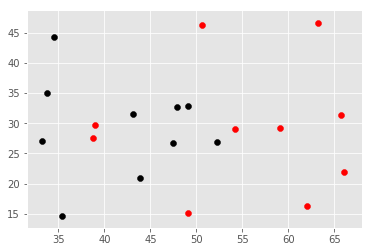



half:2	min: 83.0
[[ 12.36553566  33.23200816]
 [  0.           0.        ]
 [ 32.21301778  35.68851988]
 [ 32.92737577  27.58330724]
 [  0.           0.        ]
 [ 43.35985018  22.93472585]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.37188549  32.33951203]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 49.0824678   27.62693508]
 [ 56.10350098  32.43877974]
 [ 52.91413011  26.21839679]
 [  0.           0.        ]
 [ 34.33859823  45.1125701 ]
 [  0.           0.        ]
 [ 33.75414335  14.97246169]
 [ 48.78873321  34.33610539]]


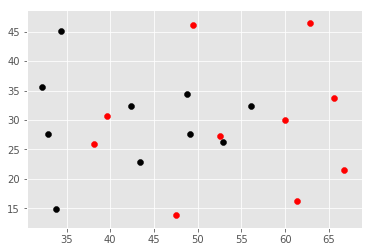



half:2	min: 84.0
[[ 12.27061948  33.30229022]
 [  0.           0.        ]
 [ 32.17954204  36.06127069]
 [ 33.09581764  27.77397153]
 [  0.           0.        ]
 [ 44.13694987  24.22182602]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 41.94706492  33.34318985]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 48.23569778  27.33716767]
 [ 47.63786782  34.67570694]
 [ 53.91280378  25.44887143]
 [  0.           0.        ]
 [ 34.26934764  45.79707776]
 [  0.           0.        ]
 [ 33.30146481  15.32232089]
 [ 49.17538192  34.57477109]]


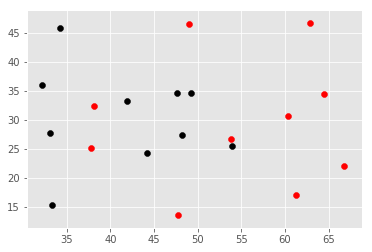



half:2	min: 85.0
[[ 12.63867258  33.28223325]
 [  0.           0.        ]
 [ 34.67881835  36.18483544]
 [ 35.37396238  27.02230393]
 [  0.           0.        ]
 [ 48.20898333  23.86791029]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 45.4250387   34.00914636]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 48.27439622  27.20073443]
 [ 46.39486443  33.82822561]
 [ 58.56640592  24.5507946 ]
 [  0.           0.        ]
 [ 37.04235983  47.68832475]
 [  0.           0.        ]
 [ 35.80906719  14.64466786]
 [ 53.58260943  33.80156188]]


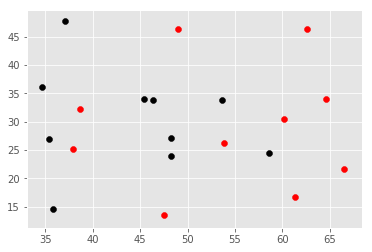



half:2	min: 86.0
[[ 12.36501061  33.50610529]
 [  0.           0.        ]
 [ 33.32807124  36.50276924]
 [ 34.31143045  27.42037216]
 [  0.           0.        ]
 [ 46.44194062  26.06491068]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 43.24399531  33.92282216]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 46.74682537  27.59989914]
 [ 41.03433867  33.63766893]
 [ 56.52273982  24.83653811]
 [  0.           0.        ]
 [ 35.49644916  47.03269569]
 [  0.           0.        ]
 [ 34.32221879  15.27202437]
 [ 51.43090012  33.0053082 ]]


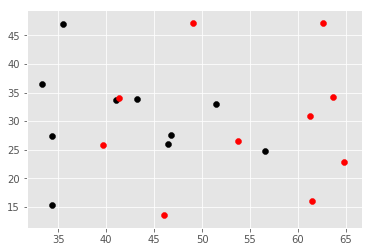



half:2	min: 87.0
[[ 11.92099602  33.46463384]
 [  0.           0.        ]
 [ 32.61614868  35.84909854]
 [ 33.79139329  26.70548241]
 [  0.           0.        ]
 [ 47.02344607  29.55616137]
 [ 54.10350933  18.58553867]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.03817297  32.16043986]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 46.66549629  27.13587836]
 [ 40.28571612  32.18680515]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.55675868  46.08920942]
 [  0.           0.        ]
 [ 31.57567865  14.5936163 ]
 [ 49.05843785  31.22281277]]


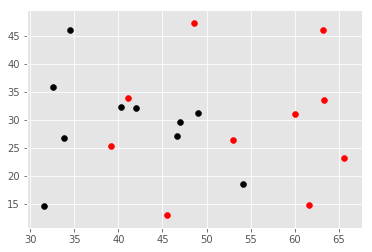



half:2	min: 88.0
[[ 11.72918311  33.91114851]
 [  0.           0.        ]
 [ 32.76039411  36.23978285]
 [ 33.90937536  26.97668777]
 [  0.           0.        ]
 [ 46.66647788  31.72858401]
 [ 54.01465519  27.15452572]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 41.923853    32.62180345]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 47.06806709  27.54731982]
 [ 42.00516169  34.29621458]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.68423027  46.66162219]
 [  0.           0.        ]
 [ 31.74711785  14.99945597]
 [ 48.76478019  30.07195814]]


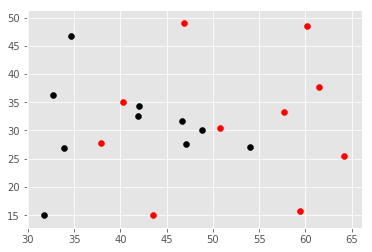



half:2	min: 89.0
[[ 12.19994273  34.53567605]
 [  0.           0.        ]
 [ 32.67552939  36.33577234]
 [ 33.84580225  27.0771431 ]
 [  0.           0.        ]
 [ 46.39508656  31.69673678]
 [ 54.01465519  27.15452572]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 41.837637    32.68734261]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 45.88054018  29.06351407]
 [ 42.00516169  34.29621458]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.61384847  46.75447376]
 [  0.           0.        ]
 [ 31.64433191  15.05883945]
 [ 48.57274601  30.1872281 ]]


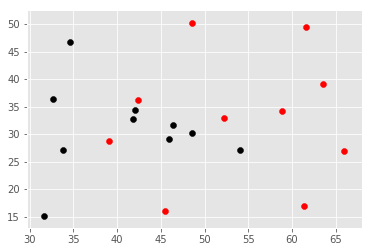



half:2	min: 90.0
[[ 11.74384432  34.48241778]
 [  0.           0.        ]
 [ 32.31382179  36.19471674]
 [ 33.47937138  27.20071439]
 [  0.           0.        ]
 [ 46.18121024  32.31175676]
 [ 55.06561945  27.53342723]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 41.45704216  32.52730137]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 44.25411268  29.53795789]
 [ 41.82945417  34.18500878]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.15798995  46.67282508]
 [  0.           0.        ]
 [ 31.61809692  14.84401687]
 [ 48.12053701  30.48231614]]


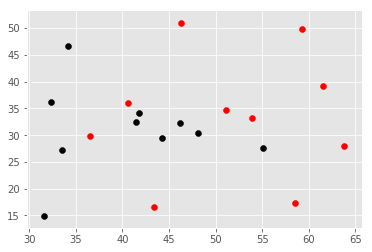



half:2	min: 91.0
[[ 11.80567937  34.81573582]
 [  0.           0.        ]
 [ 32.38452442  36.69240477]
 [ 33.67904708  27.68459228]
 [  0.           0.        ]
 [ 46.25048362  35.52091791]
 [ 54.84375147  28.87960627]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 41.51242594  33.42414679]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 44.84650533  30.34780374]
 [ 41.26089677  33.66756146]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.43965917  47.25213709]
 [  0.           0.        ]
 [ 31.39505013  15.33216078]
 [ 47.47227735  30.91753564]]


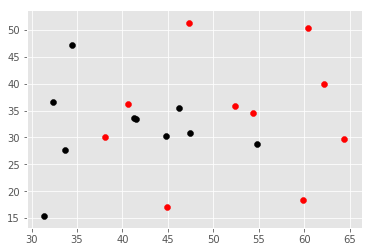



half:2	min: 92.0
[[ 12.05416653  35.05585258]
 [  0.           0.        ]
 [ 32.89523263  36.78523969]
 [ 34.09953358  27.49336609]
 [  0.           0.        ]
 [ 46.03953256  38.66676712]
 [ 57.44175345  30.37298817]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.25767197  33.80419679]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 46.18836935  29.6067548 ]
 [ 42.29258818  32.58542737]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 34.89115679  47.31261778]
 [  0.           0.        ]
 [ 31.35781467  15.17727482]
 [ 46.75857497  28.81283405]]


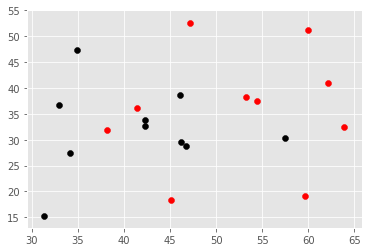



half:2	min: 93.0
[[ 11.63239825  35.23881614]
 [  0.           0.        ]
 [ 31.18011027  36.9325308 ]
 [ 31.04039831  27.04402166]
 [  0.           0.        ]
 [ 45.38161969  44.49279044]
 [ 53.3698878   31.12392412]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 42.32550783  35.96055664]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 44.4626315   30.42435724]
 [ 40.49087743  32.0157322 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 33.58903741  47.35308833]
 [  0.           0.        ]
 [ 29.42545697  16.12308667]
 [ 42.8350166   25.34490549]]


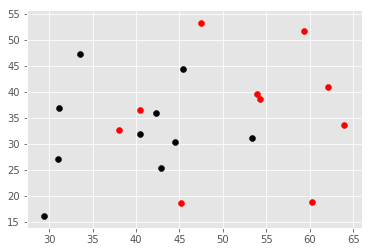



half:2	min: 94.0
[[ 11.72517776  34.9766496 ]
 [  0.           0.        ]
 [ 31.54883168  36.83204353]
 [ 30.82945702  26.5873573 ]
 [  0.           0.        ]
 [ 46.43214298  45.69802893]
 [ 54.79103965  29.88924755]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 43.29494637  36.22372585]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 45.0648157   29.88816804]
 [ 41.06268229  31.21888625]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 33.65340331  47.7291562 ]
 [  0.           0.        ]
 [ 29.78124148  15.89976267]
 [ 42.67000496  23.39415124]]


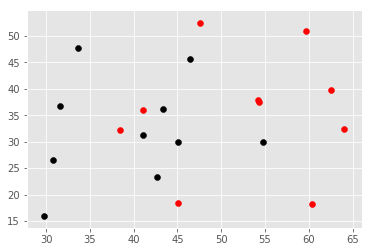



Match duration: 98.0 min
Teams' sent-off players:
[]
[]


In [14]:
with open('../data/general/matches_2017_2018_v1.json') as matches_json:
    matches = json.load(matches_json)
    

minutes_step = 15
data_height = 6000 # number of seconds in per match
data_width = 128 # number of features for vector

for match_data in matches:
   
    
    id = int(match_data['id'])
    
    if id!=60617 and id!=60634 and id!=60696 and id!=60706 and id!=60821 and id!=60845 and id!=116001326 and id==60565:

        print("\nMatch id:" + str(id))
        
        # defining 3 distinct id in game
        referee_id = 0
        home_team_id = int(match_data['homeId']) 
        away_team_id = int(match_data['awayId']) 


        # home and away player list
        home_team_player = []
        home_goal_keeper = []
        away_team_player = []
        away_goal_keeper = []


        # home_nonzero
        home_player_count_pitch = []
        home_prev_count = 11

        # home_nonzero
        away_player_count_pitch = []
        away_prev_count = 11

        # player dicts
        home_dict = {} 
        away_dict = {}
        
        # game duration
        whole_game_duration = 0

        # players position ID 
        player_positionId = {'homeTeam' : {}, 'awayTeam' : {}}


        with open('../data/match_' + str(id) + '/roster_data_' + str(id) + '.json', 'r') as file:
            match_squad = json.load(file)

        for roaster in match_squad:
            if roaster['teamId'] == home_team_id:
                home_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['homeTeam'][roaster['jerseyNumber']] = roaster['positionId'] 
                if roaster['positionId'] == 1:
                    home_goal_keeper.append(str(roaster['jerseyNumber']))


            elif roaster['teamId'] == away_team_id:
                away_team_player.append(str(roaster['jerseyNumber']))
                player_positionId['awayTeam'][roaster['jerseyNumber']] = roaster['positionId']
                if roaster['positionId'] == 1:
                    away_goal_keeper.append(str(roaster['jerseyNumber']))


        # home players dict data
        home_team_player.sort(key=int)
        home_goal_keeper.sort(key=int)
        home_val = np.arange(0, len(home_team_player))
        home_dict = dict(zip(home_team_player, home_val))
        home_dict_reverse = dict(zip(home_val, home_team_player))


        # away players dict data
        away_team_player.sort(key=int)
        away_goal_keeper.sort(key=int)
        away_val = np.arange(0, len(away_team_player))
        away_dict = dict(zip(away_team_player, away_val))
        away_dict_reverse = dict(zip(away_val, away_team_player))

        # home and away team players' status[0: not playing, 1: playing, 2-left the game], enter status[0: enter 1st half, 1: enter second half],
        # enter time, and duration, red card
        home_dur_in_out = np.zeros(shape=(len(home_team_player), 5), dtype=np.float)
        away_dur_in_out = np.zeros(shape=(len(away_team_player), 5), dtype=np.float)


        with open('../data/match_' + str(id) + '/players_data_' + str(id) + '.json', 'r') as file:
            player_data = json.load(file)


        for player in player_data:
            jersey_number = player['jerseyNumber']
            if player['teamId'] == home_team_id:
                home_dur_in_out[home_dict[str(jersey_number)]][3] = player['duration']
                home_dur_in_out[home_dict[str(jersey_number)]][4] = player['redCard']



            elif player['teamId'] == away_team_id:
                away_dur_in_out[away_dict[str(jersey_number)]][3] = player['duration']
                away_dur_in_out[away_dict[str(jersey_number)]][4] = player['redCard']



        # home and away team player pos and activity count: 0-xpos, 1-ypos
        home_pos_count = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
        home_activity_count = np.zeros(shape=(len(home_team_player), 1), dtype=np.int)
        home_activity_count_all = np.zeros(shape=(len(home_team_player), 2), dtype=np.int)
        home_act_nozero = [0,0] # number non-zero activity_count_all


        away_pos_count = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)
        away_activity_count = np.zeros(shape=(len(away_team_player), 1), dtype=np.int)
        away_activity_count_all = np.zeros(shape=(len(away_team_player), 2), dtype=np.int)
        away_act_nozero = [0,0] # number non-zero activity_count_all


        # home and away team player count data for 10 min: 0-xpos, 1-ypos / 0-1min, 1-2min... 9-10min 
        home_pos_count_minutes = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        home_pos_count_minutes2 = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes2 = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes2 = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)


        # home and away team Mean pos data: 0-xpos, 1-ypos
        home_pos_mean = np.zeros(shape=(len(home_team_player), 2), dtype=np.float)
        away_pos_mean = np.zeros(shape=(len(away_team_player), 2), dtype=np.float)


        # create array of x input data for every match
        x_intput = np.ndarray(shape=(data_height, data_width), dtype=np.float)



        with open('../data/match_' + str(id) + '/per_sec_data_' + str(id) + '.json', 'r') as file:
            data_persec = json.load(file)

        home_pos_count_minutes = np.zeros(shape=(len(home_team_player), 2, minutes_step), dtype=np.float)
        home_activity_count_minutes = np.zeros(shape=(len(home_team_player), minutes_step), dtype=np.int)

        away_pos_count_minutes = np.zeros(shape=(len(away_team_player), 2, minutes_step), dtype=np.float)
        away_activity_count_minutes = np.zeros(shape=(len(away_team_player), minutes_step), dtype=np.int)

        # create first average positon data for assigning player position at the 1st half
        # temporary t
        
        home_activity_count_all[0: len(home_team_player)] = 0
        away_activity_count_all[0: len(away_team_player)] = 0

        
        tmp_t = 0
        shift_times_right = 0
        
        # threshol second:
        threshold_second = 60

        # 1st half duration
        first_half_duration = 0

        home_nonzero = 11
        away_nonzero = 11

        prev_home_nonzero = 11
        prev_away_nonzero = 11


        # temporary half
        tmp_half = 1

        c_activity_value = 0
        c_home_activity_each = 0
        c_away_activity_each = 0

        while c_activity_value==0:

            c_home_activity_each = 0
            c_away_activity_each = 0

            a,b = fist_time_step_mean_data(1, data_persec)


            for player_home in range(0, len(home_team_player)):
                res = caluclate_activity_count(minutes_step, player_home, a)
                c_home_activity_each += res

            for player_away in range(0, len(away_team_player)):
                res = caluclate_activity_count(minutes_step, player_away, b)
                c_away_activity_each += res

            if c_home_activity_each == 11 and c_away_activity_each == 11:
                c_activity_value = 1

            threshold_second += 60  

        threshold_second -= 1
        
        print("1st half start: " + str(threshold_second) + " sec")
        
        
        for d in data_persec:

            match_half_t = int(d['half'])

            # create first average positon data for assigning player at the 2nd half
            if match_half_t != tmp_half and match_half_t==2:
                tmp_half = match_half_t
                shift_times_right = 0

                tmp_t = 45*60

                activity_home_nonzero = 0
                activity_away_nonzero = 0
                home_break_subs = []
                away_break_subs = []
                home_break_subs_after = []
                away_break_subs_after = []

                for player_home in range(0, len(home_team_player)):
                    if home_pos_mean[player_home][0] !=0:
                            activity_home_nonzero += 1
                            home_break_subs.append(1)
                    else:
                        home_break_subs.append(0)


                for player_away in range(0, len(away_team_player)):
                    if away_pos_mean[player_away][0] !=0:
                            activity_away_nonzero += 1
                            away_break_subs.append(1)
                    else:
                        away_break_subs.append(0)

                home_nonzero = activity_home_nonzero
                away_nonzero = activity_away_nonzero


                # clear home team data
                home_pos_count[0: len(home_team_player)] = 0
                home_activity_count[0: len(home_team_player)] = 0 
                home_activity_count_all[0: len(home_team_player)] = 0
                home_act_nozero = [0,0]
                home_pos_count_minutes[0: len(home_team_player)] = 0
                home_activity_count_minutes[0: len(home_team_player)] = 0
                home_pos_mean[0: len(home_team_player)] = 0

                # clear away team data
                away_pos_count[0: len(away_team_player)] = 0
                away_activity_count[0: len(away_team_player)] = 0 
                away_activity_count_all[0: len(away_team_player)] = 0
                away_act_nozero = [0,0]
                away_pos_count_minutes[0: len(away_team_player)] = 0
                away_activity_count_minutes[0: len(away_team_player)] = 0
                away_pos_mean[0: len(away_team_player)] = 0


                threshold_second = 60

                c_activity_value = 0
                c_home_activity_each = 0
                c_away_activity_each = 0

                while c_activity_value==0:

                    c_home_activity_each = 0
                    c_away_activity_each = 0

                    home_break_subs_after = []
                    away_break_subs_after = []

                    a,b = fist_time_step_mean_data(2, data_persec)

                    for player_home in range(0, len(home_team_player)):
                        res = caluclate_activity_count(minutes_step, player_home, a)
                        c_home_activity_each += res
                        home_break_subs_after.append(res)

                    for player_away in range(0, len(away_team_player)):
                        res = caluclate_activity_count(minutes_step, player_away, b)
                        c_away_activity_each += res
                        away_break_subs_after.append(res)


                    if c_home_activity_each == activity_home_nonzero and c_away_activity_each == activity_away_nonzero:
                        c_activity_value = 1

                    threshold_second += 60


                for player_home_2 in range(0, len(home_team_player)):
                    if home_break_subs_after[player_home_2]==0 and home_break_subs[player_home_2]==1:
                        home_dur_in_out[player_home_2][0] = 2 # menas goal keepr has left the game

                for player_away_2 in range(0, len(away_team_player)):
                    if away_break_subs_after[player_away_2]==0 and away_break_subs[player_away_2]==1:
                        away_dur_in_out[player_away_2][0] = 2 # menas goal keepr has left the game

                threshold_second -= 1
                
                print("2nd half start: " + str(threshold_second) + " sec")


            i = int(d['minute'])*60 + int(d['second'])
            x_pos = d['xpos']
            y_pos = d['ypos']
            team_id_t = int(d['teamId'])
            jersey_number_t = int(d['jerseyNumber'])
            has_ball_teamId_t = int(d['hasballTeamId'])


            # find out how long did 1st half last
            if match_half_t == 1:
                first_half_duration = i


            if i%60==59:

                if team_id_t == home_team_id:
                    player = home_dict[str(jersey_number_t)]
                    home_activity_count_all[player][1] = 1

                elif team_id_t == away_team_id:
                    player = away_dict[str(jersey_number_t)]
                    away_activity_count_all[player][1] = 1



            if i%60!=0:    

                if team_id_t == home_team_id:

                    if home_dur_in_out[home_dict[str(jersey_number_t)]][0] == 0:
                        home_dur_in_out[home_dict[str(jersey_number_t)]][0] = 1 # indicates that a player is in game 
                        home_dur_in_out[home_dict[str(jersey_number_t)]][1] = match_half_t # enter half
                        home_dur_in_out[home_dict[str(jersey_number_t)]][2] = i  # enter time


                        plyr_position = player_positionId['homeTeam'][jersey_number_t]
                        player = home_dict[str(jersey_number_t)]
                        home_pos_count_minutes[player][1][minutes_step-1] += 34
                        home_activity_count_minutes[player][minutes_step-1] +=1


                        if plyr_position == 1:
                            home_pos_count_minutes[player][0][minutes_step-1] += 10
                        elif plyr_position == 2:
                            home_pos_count_minutes[player][0][minutes_step-1] += 38
                        elif plyr_position == 3:
                            home_pos_count_minutes[player][0][minutes_step-1] += 58
                        else:
                            home_pos_count_minutes[player][0][minutes_step-1] += 78

                    if i<((home_dur_in_out[home_dict[str(jersey_number_t)]][2])+60) and home_dur_in_out[home_dict[str(jersey_number_t)]][0] == 1:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1 

                    elif player_positionId['homeTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1

                    elif has_ball_teamId_t == away_team_id:
                        if x_pos!=0 and y_pos!=0:
                            home_pos_count[home_dict[str(jersey_number_t)]][0] += x_pos
                            home_pos_count[home_dict[str(jersey_number_t)]][1] += y_pos
                            home_activity_count[home_dict[str(jersey_number_t)]] +=1 

                elif team_id_t == away_team_id:

                    if away_dur_in_out[away_dict[str(jersey_number_t)]][0] == 0:
                        away_dur_in_out[away_dict[str(jersey_number_t)]][0] = 1 # indicates that a player is in game
                        away_dur_in_out[away_dict[str(jersey_number_t)]][1] = match_half_t # enter half 
                        away_dur_in_out[away_dict[str(jersey_number_t)]][2] = i #enter time

                        plyr_position = player_positionId['awayTeam'][jersey_number_t]
                        player = away_dict[str(jersey_number_t)]
                        away_pos_count_minutes[player][1][minutes_step-1] += 34
                        away_activity_count_minutes[player][minutes_step-1] +=1


                        if plyr_position == 1:
                            away_pos_count_minutes[player][0][minutes_step-1] += 10
                        elif plyr_position == 2:
                            away_pos_count_minutes[player][0][minutes_step-1] += 38
                        elif plyr_position == 3:
                            away_pos_count_minutes[player][0][minutes_step-1] += 58
                        else:
                            away_pos_count_minutes[player][0][minutes_step-1] += 78


                    if i<((away_dur_in_out[away_dict[str(jersey_number_t)]][2])+60) and away_dur_in_out[away_dict[str(jersey_number_t)]][0] == 1:
                        if x_pos!=0 and y_pos!=0:
                            away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                            away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                            away_activity_count[away_dict[str(jersey_number_t)]] +=1

                    elif player_positionId['awayTeam'][jersey_number_t] == 1 and has_ball_teamId_t != 0:
                        away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                        away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                        away_activity_count[away_dict[str(jersey_number_t)]] +=1

                    elif has_ball_teamId_t == home_team_id:
                         if x_pos!=0 and y_pos!=0:
                            away_pos_count[away_dict[str(jersey_number_t)]][0] += x_pos
                            away_pos_count[away_dict[str(jersey_number_t)]][1] += y_pos
                            away_activity_count[away_dict[str(jersey_number_t)]] +=1 

                elif team_id_t == referee_id:
                    pass
                    # referee_pos_t['xpos']
                    # referee_pos_t['ypos']

            # shifing last index of 15min arry (period of 15min) with last min data
            # and calculate mena position of each player each min based on previus 10 min
            if i%60 == 0 and tmp_t != i+1 and (i-(match_half_t-1)*45*60)>threshold_second:


                tmp_t = i+1

                prev_home_nonzero = home_nonzero
                home_nonzero = 0

                prev_away_nonzero = away_nonzero
                away_nonzero = 0


                if shift_times_right !=0:
                    for player_home in range(0, len(home_team_player)):

                        home_pos_count_minutes[player_home][0] = (shift(home_pos_count_minutes[player_home][0], -1, cval=0))
                        home_pos_count_minutes[player_home][1] = (shift(home_pos_count_minutes[player_home][1], -1, cval=0))
                        home_activity_count_minutes[player_home] = (shift(home_activity_count_minutes[player_home], -1, cval=0))

                        home_pos_count_minutes[player_home][0][minutes_step-1] = home_pos_count[player_home][0]
                        home_pos_count_minutes[player_home][1][minutes_step-1] = home_pos_count[player_home][1]
                        home_activity_count_minutes[player_home][minutes_step-1] = home_activity_count[player_home]


                    for player_away in range(0, len(away_team_player)):

                        away_pos_count_minutes[player_away][0] = (shift(away_pos_count_minutes[player_away][0], -1, cval=0))
                        away_pos_count_minutes[player_away][1] = (shift(away_pos_count_minutes[player_away][1], -1, cval=0))
                        away_activity_count_minutes[player_away] = (shift(away_activity_count_minutes[player_away], -1, cval=0))

                        away_pos_count_minutes[player_away][0][minutes_step-1] = away_pos_count[player_away][0]
                        away_pos_count_minutes[player_away][1][minutes_step-1] = away_pos_count[player_away][1]
                        away_activity_count_minutes[player_away][minutes_step-1] = away_activity_count[player_away]


                shift_times_right = 1


                # clear home team
                home_pos_count[0: len(home_team_player)] = 0
                home_activity_count[0: len(home_team_player)] = 0

                # clear away team
                away_pos_count[0: len(away_team_player)] = 0
                away_activity_count[0: len(away_team_player)] = 0


                home_pos_mean[0:len(home_team_player)] = 0
                home_act_nozero = [0,0]

                away_pos_mean[0:len(away_team_player)] = 0
                away_act_nozero = [0,0]



                for player_home in range(0, len(home_team_player)):
                    jersey_n = int(home_dict_reverse[player_home])
                    if player_positionId['homeTeam'][jersey_n] == 1 and home_dur_in_out[player_home][0]==1 and home_activity_count_all[player_home][1] == 0:
                        action_status_exit = 0
                        
                        if home_dur_in_out[player_home][4]==1:
                            enter_half = home_dur_in_out[player_home][1]
                            enter_time = home_dur_in_out[player_home][2]
                            p_game_play_dur = home_dur_in_out[player_home][3]

                            h = match_half_t
                            f_h_d= first_half_duration

                            if enter_half == 1:
                                current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                            elif enter_half == 2:
                                current_play_dur = math.floor( (i - enter_time)/60 )

                            if current_play_dur < p_game_play_dur:


                                for gk_i in home_goal_keeper:
                                    if home_activity_count_all[home_dict[str(gk_i)]][1] !=0:
                                        home_dur_in_out[player_home][0] = 2 # menas goal keepr has left the game
                                        home_pos_mean[player_home][0] = 0 
                                        home_pos_mean[player_home][1] = 0
                                        action_status_exit = 1
                        else:
                            for gk_i in home_goal_keeper:
                                if home_activity_count_all[home_dict[str(gk_i)]][1] !=0:
                                    home_dur_in_out[player_home][0] = 2 # menas goal keepr has left the game
                                    home_pos_mean[player_home][0] = 0 
                                    home_pos_mean[player_home][1] = 0
                                    action_status_exit = 1
                            

                        if action_status_exit == 0:
                            home_activity_count_all[player_home][1] = 1

                    if (home_activity_count_all[player_home][0]==1):
                        home_act_nozero[0] += 1

                    if (home_activity_count_all[player_home][1]==1):
                        home_act_nozero[1] += 1
                        
                

                for player_away in range(0, len(away_team_player)):
                    jersey_n = int(away_dict_reverse[player_away])
                    if player_positionId['awayTeam'][jersey_n] == 1 and away_dur_in_out[player_away][0]==1 and away_activity_count_all[player_away][1] == 0:
                        action_status_exit = 0
                        
                        if away_dur_in_out[player_away][4]==1:

                            # player current and whole game duration durng match
                            enter_half = away_dur_in_out[player_away][1]
                            enter_time = away_dur_in_out[player_away][2]
                            p_game_play_dur = away_dur_in_out[player_away][3]

                            h = match_half_t
                            f_h_d= first_half_duration

                            if enter_half == 1:
                                current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                            elif enter_half == 2:
                                current_play_dur = math.floor( (i - enter_time)/60 )

                            if current_play_dur < p_game_play_dur:

                                for gk_i in away_goal_keeper:
                                    if away_activity_count_all[away_dict[str(gk_i)]][1] !=0:
                                        away_dur_in_out[player_away][0] = 2 # menas goal keepr has left the game
                                        away_pos_mean[player_away][0] = 0 
                                        away_pos_mean[player_away][1] = 0
                                        action_status_exit = 1
                        else:
                            for gk_i in away_goal_keeper:
                                if away_activity_count_all[away_dict[str(gk_i)]][1] !=0:
                                    away_dur_in_out[player_away][0] = 2 # menas goal keepr has left the game
                                    away_pos_mean[player_away][0] = 0 
                                    away_pos_mean[player_away][1] = 0
                                    action_status_exit = 1
                            
                        if action_status_exit == 0:
                            away_activity_count_all[player_away][1] = 1


                    if (away_activity_count_all[player_away][0]!=0):
                        away_act_nozero[0] += 1

                    if (away_activity_count_all[player_away][1]!=0):
                        away_act_nozero[1] += 1

                home_subs_count_check = 0
                home_subs_count_id = 0
                home_2subs_array_in = []
                home_2subs_array_out = []


                for player_home in range(0, len(home_team_player)):
                  

                    if home_activity_count_all[player_home][1] != 0 and home_dur_in_out[player_home][0]==1:

                        caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)

                        if home_act_nozero[0]-home_act_nozero[1]<0 and home_act_nozero[0]!=0 and home_activity_count_all[player_home][0] == 0:
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0
                            home_activity_count_all[player_home][1] = 0


                    elif home_activity_count_all[player_home][1] == 0 and home_dur_in_out[player_home][0]==1 and home_dur_in_out[player_home][4]==1: 
                        # player current and whole game duration durng match


                        enter_half = home_dur_in_out[player_home][1]
                        enter_time = home_dur_in_out[player_home][2]
                        p_game_play_dur = home_dur_in_out[player_home][3]

                        h = match_half_t
                        f_h_d= first_half_duration

                        if enter_half == 1:
                            current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                        elif enter_half == 2:
                            current_play_dur = math.floor( (i - enter_time)/60 )

                        if current_play_dur < p_game_play_dur:
                            caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)
                            home_activity_count_all[player_home][1] = 1
                        else:
                            home_dur_in_out[player_home][0] = 2
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0


                    elif home_activity_count_all[player_home][1] == 0 and home_dur_in_out[player_home][0]==1:

                        if (home_act_nozero[0] == home_act_nozero[1]):
                            home_dur_in_out[player_home][0]=2
                            home_pos_mean[player_home][0] = 0 
                            home_pos_mean[player_home][1] = 0

                        elif home_act_nozero[0] > home_act_nozero[1]:
                            caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)
                            home_activity_count_all[player_home][1] = 1
                            home_subs_count_check += 1
                            home_2subs_array_out.append(player_home)
                            home_subs_count_id = player_home

                    else:

                        home_pos_mean[player_home][0] = 0 
                        home_pos_mean[player_home][1] = 0


                for player_home in range(0, len(home_team_player)):
                    if home_subs_count_check >=1 and (home_act_nozero[0]-home_act_nozero[1]==1):

                        d = caluclate_nzero_activity_count(minutes_step, 0, home_subs_count_id, home_activity_count_minutes)
                        if home_activity_count_all[player_home][0] == 0 and home_activity_count_all[player_home][1] == 1:
                            
                            if d==14:
                                d-=2
                            result = caluclate_nzero_activity_count(minutes_step, d+1, player_home, home_activity_count_minutes)
                            if result != -1:
                                home_2subs_array_in.append(player_home)

                    home_activity_count_all[player_home][0] = home_activity_count_all[player_home][1]
                    home_activity_count_all[player_home][1] = 0



                # number of last non-zero activties
                home_last_nz_act_count = caluclate_last_nzero_ac_count(len(home_team_player), home_activity_count_all)



                if home_last_nz_act_count == prev_home_nonzero and len(home_2subs_array_out)==2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        if home_activity_count_minutes[player][minutes_step-1] == 0:
                            home_dur_in_out[player][0] = 2
                            home_activity_count_all[player][0] = 0
                            home_pos_mean[player][0] = 0
                            home_pos_mean[player][1] = 0


                if len(home_2subs_array_out)>=2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        home_activity_count_all[player][0] = 1
                        caluclate_avrg_pos(minutes_step, home_pos_mean, player_home, home_pos_count_minutes, 
                                           home_activity_count_minutes)


                if len(home_2subs_array_in) == 2 and len(home_2subs_array_out)==2:
                    for home_2subs_i in range(0,2):
                        player = home_2subs_array_out[home_2subs_i]
                        home_dur_in_out[player][0] = 2
                        home_activity_count_all[player][0] = 0
                        home_pos_mean[player][0] = 0
                        home_pos_mean[player][1] = 0

                if len(home_2subs_array_in) == 1 and len(home_2subs_array_out)>=2:
                    player = home_2subs_array_in[0]
                    home_activity_count_all[player][0] = 0
                    home_pos_mean[player][0] = 0
                    home_pos_mean[player][1] = 0


                if home_act_nozero[0]-home_act_nozero[1]==1 and home_subs_count_check==1 and len(home_2subs_array_in) == 1:
                    player_out = home_2subs_array_out[0]
                    home_dur_in_out[player_out][0] = 2
                    home_activity_count_all[player_out][0] = 0
                    home_pos_mean[player_out][0] = 0
                    home_pos_mean[player_out][1] = 0


                for player_home in range(0, len(home_team_player)):
                    if home_pos_mean[player_home][0] !=0:
                        home_nonzero += 1


                    jersey_n = home_dict_reverse[player_home]
                    if player_positionId['homeTeam'][int(jersey_n)] == 1:
                        pass
                    elif home_pos_mean[player_home][0]!=0 and home_pos_mean[player_home][1]!=0:
                        plt.scatter(home_pos_mean[player_home][0], home_pos_mean[player_home][1], marker="o", color="k", linewidths=0.5)


                away_subs_count_check = 0
                away_subs_count_id = 0
                away_2subs_array_in = []
                away_2subs_array_out = []

                for player_away in range(0, len(away_team_player)):


                    if away_activity_count_all[player_away][1] != 0 and away_dur_in_out[player_away][0]==1:

                        caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                               away_activity_count_minutes)

                        if away_act_nozero[0]-away_act_nozero[1]<0 and away_act_nozero[0]!=0 and away_activity_count_all[player_away][0] == 0:
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0
                            away_activity_count_all[player_away][1] = 0

                    elif away_activity_count_all[player_away][1] == 0 and away_dur_in_out[player_away][0]==1 and away_dur_in_out[player_away][4]==1:


                        # player current and whole game duration durng match
                        enter_half = away_dur_in_out[player_away][1]
                        enter_time = away_dur_in_out[player_away][2]
                        p_game_play_dur = away_dur_in_out[player_away][3]

                        h = match_half_t
                        f_h_d= first_half_duration



                        if enter_half == 1:
                            current_play_dur = math.floor( ((f_h_d - enter_time) + (i-45*60)*(h-1) )/60 )
                        elif enter_half == 2:
                            current_play_dur = math.floor( (i - enter_time)/60 )



                        if current_play_dur < p_game_play_dur:
                            caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                           away_activity_count_minutes)
                            away_activity_count_all[player_away][1] = 1

                        else:
                            away_dur_in_out[player_away][0] = 2
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0


                    elif away_activity_count_all[player_away][1] == 0 and away_dur_in_out[player_away][0]==1:

                        if away_act_nozero[0] == away_act_nozero[1]:
                            away_dur_in_out[player_away][0] = 2
                            away_pos_mean[player_away][0] = 0 
                            away_pos_mean[player_away][1] = 0


                        elif away_act_nozero[0] > away_act_nozero[1]:
                            caluclate_avrg_pos(minutes_step, away_pos_mean, player_away, away_pos_count_minutes, 
                                           away_activity_count_minutes)
                            away_activity_count_all[player_away][1] = 1
                            away_subs_count_check += 1
                            away_2subs_array_out.append(player_away)
                            away_subs_count_id = player_away

                    else:
                        away_pos_mean[player_away][0] = 0 
                        away_pos_mean[player_away][1] = 0


                for player_away in range(0, len(away_team_player)):
                    if away_subs_count_check >= 1 and (away_act_nozero[0]-away_act_nozero[1]==1):
                            d = caluclate_nzero_activity_count(minutes_step, 0, away_subs_count_id, away_activity_count_minutes)
                            if away_activity_count_all[player_away][0] ==0 and away_activity_count_all[player_away][1] == 1:
                                if d==14:
                                    d-=2
                                result = caluclate_nzero_activity_count(minutes_step, d+1, player_away, away_activity_count_minutes)
                                if result != -1:
                                    away_2subs_array_in.append(player_away)

                    away_activity_count_all[player_away][0] = away_activity_count_all[player_away][1]
                    away_activity_count_all[player_away][1] = 0


                # number of last non-zero activties
                away_last_nz_act_count = caluclate_last_nzero_ac_count(len(away_team_player), away_activity_count_all)

                if away_last_nz_act_count == prev_away_nonzero and len(away_2subs_array_out)==2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        if away_activity_count_minutes[player][minutes_step-1] == 0:
                            away_dur_in_out[player][0] = 2
                            away_activity_count_all[player][0] = 0
                            away_pos_mean[player][0] = 0
                            away_pos_mean[player][1] = 0


                if len(away_2subs_array_out)>=2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        away_activity_count_all[player][0] = 1

                if len(away_2subs_array_in) == 2 and away_subs_count_check==2:
                    for away_2subs_i in range(0,2):
                        player = away_2subs_array_out[away_2subs_i]
                        away_dur_in_out[player][0] = 2
                        away_activity_count_all[player][0] = 0
                        away_pos_mean[player][0] = 0
                        away_pos_mean[player][1] = 0

                if len(away_2subs_array_in) == 1 and away_subs_count_check>=2:
                    player = away_2subs_array_in[0]
                    away_activity_count_all[player][0] = 0
                    away_pos_mean[player][0] = 0
                    away_pos_mean[player][1] = 0

                if away_act_nozero[0]-away_act_nozero[1]==1 and away_subs_count_check==1 and len(away_2subs_array_in) == 1:
                    player_out = away_2subs_array_out[0]
                    away_dur_in_out[player_out][0] = 2
                    away_activity_count_all[player_out][0] = 0
                    away_pos_mean[player_out][0] = 0
                    away_pos_mean[player_out][1] = 0
                    
    
                for player_away in range(0, len(away_team_player)):
                    if away_pos_mean[player_away][0] !=0:
                        away_nonzero += 1


                    jersey_n = away_dict_reverse[player_away]
                    if player_positionId['awayTeam'][int(jersey_n)] == 1:
                        pass
                    elif away_pos_mean[player_away][0]!=0 and away_pos_mean[player_away][1]!=0:
                        plt.scatter(away_pos_mean[player_away][0], away_pos_mean[player_away][1], marker="o", color="r", linewidths=0.5)
                

                if home_nonzero != home_prev_count:
                    home_player_count_pitch.append(str("half:") + str(match_half_t) +" min:" + str((i)/60+(match_half_t-1)*(math.floor(first_half_duration/60)-45)) + " number: " + str(home_nonzero))
                    home_prev_count = home_nonzero

                if away_nonzero != away_prev_count:
                    away_player_count_pitch.append(str("half:") + str(match_half_t) +" min:" + str((i)/60+(match_half_t-1)*(math.floor(first_half_duration/60)-45)) + " number: " + str(away_nonzero))
                    away_prev_count = away_nonzero
                    
                whole_game_duration = i/60
                    
                
                print("half:" + str(match_half_t) +"\tmin: " + str((i)/60))
                print(home_pos_mean)
                plt.show()
                print('\n')        
                

        # show if player has left the game
        print("Match duration: " + str(whole_game_duration + (math.floor(first_half_duration/60)-45))  + " min")
        print("Teams' sent-off players:")
        print(home_player_count_pitch)
        print(away_player_count_pitch)